# Introduction: Finding Supernova Neutrinos
To date, we have only managed to detect the neutrinos from one supernova, which arrived at Earth on the 23rd February 1987 and is known by the snappy name SN1987A. This project will investigate the feasibility of identifying supernova neutrino events in a new type of detector called a Liquid-Argon Time-Projection Chamber (LArTPC). These detectors give incredibly high-resolution 'images' of the charged-particle tracks produced when a neutrino interacts in the detector. 

### Physics Motivation
Supernovae are stellar explosions that produce enormous quantities of neutrinos. These neutrinos escape the stellar core hours before the optical explosion becomes visible, making their detection a potential early warning system for supernova events. As we can learn a great deal about high-energy Physics from spectroscopic data of supernovae events, having an early warning system in place would be beneficial to the field of Physics.

### Notebook Data
The data for this project comes in the form of the following files:

| File | Description |
| ----------- | ----------- |
| larImages.npy | A numpy array of 10,000 100x100 pixel images |
| meta.npy | The meta information about the particles in the image |

The images show the energy deposited in the liquid argon detector within a small slice of space and time. The meta information contains the following 64 numbers for each image. The [PDG code](https://pdg.lbl.gov/2019/reviews/rpp2019-rev-monte-carlo-numbering.pdf) is a number which identifies the particle type (e.g electron=11, electron-neutrino=12, etc.).

| Column | Description |
| ----------- | ----------- |
| 0 | Row number |
| 1 | Neutrino Energy (MeV) |
| 2 | Initial state particles (always 2) |
| 3 | Final state particles (varies) |
| 4-8 | Initial Particle 1: PDG code, Total Energy (MeV), $p_x$, $p_y$, $p_z$ | 
| 9-13 | Initial Particle 2: PDG code, Total Energy (MeV), $p_x$, $p_y$, $p_z$ |
| 14-18 | Final Particle 1: PDG code, Total Energy (MeV), $p_x$, $p_y$, $p_z$ | 
| 19-23 | Final Particle 2: PDG code, Total Energy (MeV), $p_x$, $p_y$, $p_z$ |
| $\vdots$ | Final Particle N: PDG code, Total Energy (MeV), $p_x$, $p_y$, $p_z$ |
| 59-63 | Final Particle 10: PDG code, Total Energy (MeV), $p_x$, $p_y$, $p_z$ |

### Machine Learning Tasks
This notebook aims to use machine learning techniques to analyze simulated data from a Liquid-Argon Time-Projection Chamber (LArTPC) detector. Our goal is to identify supernova neutrino events, reconstruct their properties, and distinguish them from background noise. 
1. Successfully simulate realistic electronic noise in the detector.
2. Develop a machine learning classifier that can successfully classify 'clean' simulated neutrinos from 'empty' slices with electronic noise.
3. Test the machine learning classifier on 


### Expected Challenges




# Misc: Data Loading and Imports

First, we import necessary modules:

In [41]:
# Import libraries
from __future__ import annotations
import os
import json
import numpy as np
from typing import Tuple, Dict
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras import models, layers, optimizers, regularizers, losses, metrics, callbacks
import keras_tuner as kt
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.layers import GlobalAveragePooling2D, Add, UpSampling2D, Concatenate, Reshape, Multiply, ZeroPadding2D
from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, mean_absolute_error, r2_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from scipy import ndimage

# Configure matplotlib
plt.style.use('default')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

print(f"TensorFlow version: {tf.__version__}")
print(f"NumPy version: {np.__version__}")

TensorFlow version: 2.19.0
NumPy version: 2.1.3


Now we load the neutrino data and extract properties.

In [6]:
# Load the neutrino event data
images = np.load('larImages.npy')
metadata = np.load('meta.npy')
print(f"Images shape: {images.shape}")
print(f"Metadata shape: {metadata.shape}")

# Reshape images to include channel dimension
images = images.reshape(10000, 100, 100, 1).astype(np.float32)

# Extract metadata based on column
neutrino_energies = metadata[:, 1]  # Column 1: Neutrino Energy (MeV)
final_state_counts = metadata[:, 3].astype(int)  # Column 3: Final state particles

print(f"Data Statistics:")
print(f"  Neutrino energy range: {np.min(neutrino_energies):.2f} - {np.max(neutrino_energies):.2f} MeV")
print(f"  Mean neutrino energy: {np.mean(neutrino_energies):.2f} MeV")
print(f"  Final state particle range: {np.min(final_state_counts)} - {np.max(final_state_counts)}")
print(f"  Mean final state particles: {np.mean(final_state_counts):.1f}")
print(f"  Image range: {np.min(images):.4f} - {np.max(images):.4f}")

# Calculate typical signal strength for noise scaling
non_zero_pixels = images[images > 0]
typical_signal_strength = np.mean(non_zero_pixels)

# Start off noise strength at 15% of signal strength
noise_strength = typical_signal_strength * 0.15
print(f"  Typical signal strength: {typical_signal_strength:.4f}")
print(f"  Typical noise strength (15% of signal): {noise_strength:.4f}")

Images shape: (10000, 100, 100)
Metadata shape: (10000, 64)
Data Statistics:
  Neutrino energy range: 4.49 - 59.93 MeV
  Mean neutrino energy: 21.65 MeV
  Final state particle range: 3 - 10
  Mean final state particles: 5.2
  Image range: 0.0000 - 106.0000
  Typical signal strength: 4.6560
  Typical noise strength (15% of signal): 0.6984


Visualising sample neutrino events:

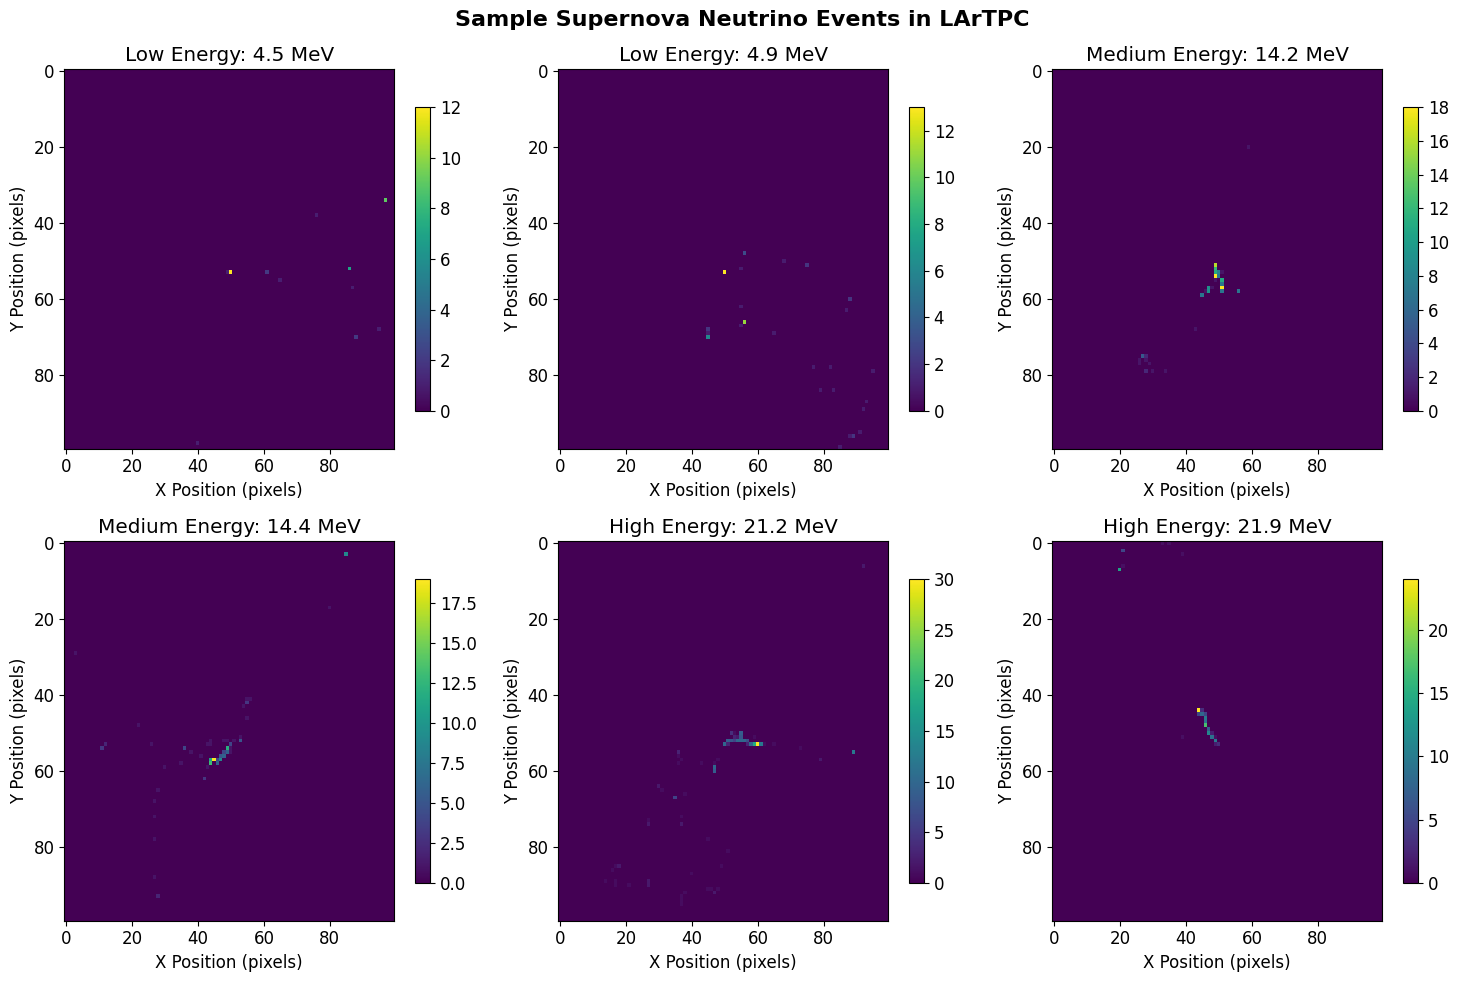

In [7]:
# Visualize sample neutrino events
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Sample Supernova Neutrino Events in LArTPC', fontsize=16, fontweight='bold')

for i in range(6):
    row, col = divmod(i, 3)
    
    # Select events with different energy ranges
    if i < 2:
        idx = np.where(neutrino_energies < 5)[0][i]
        energy_label = "Low Energy"
    elif i < 4:
        idx = np.where((neutrino_energies >= 5) & (neutrino_energies < 15))[0][i-2]
        energy_label = "Medium Energy"
    else:
        idx = np.where(neutrino_energies >= 15)[0][i-4]
        energy_label = "High Energy"
    
    im = axes[row, col].imshow(images[idx, :, :, 0], cmap='viridis', aspect='auto')
    axes[row, col].set_title(f'{energy_label}: {neutrino_energies[idx]:.1f} MeV')
    axes[row, col].set_xlabel('X Position (pixels)')
    axes[row, col].set_ylabel('Y Position (pixels)')
    plt.colorbar(im, ax=axes[row, col], shrink=0.8)

plt.tight_layout()
plt.show()

Distribution of energy within data:

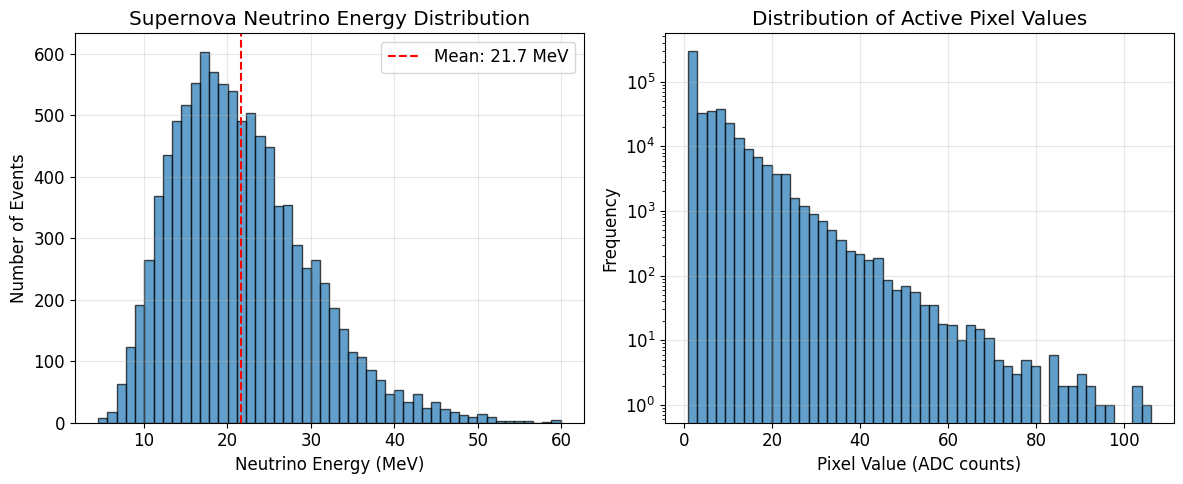

In [8]:
# Energy distribution
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(neutrino_energies, bins=50, alpha=0.7, edgecolor='black')
plt.axvline(np.mean(neutrino_energies), color='red', linestyle='--', 
           label=f'Mean: {np.mean(neutrino_energies):.1f} MeV')
plt.xlabel('Neutrino Energy (MeV)')
plt.ylabel('Number of Events')
plt.title('Supernova Neutrino Energy Distribution')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(images[images > 0].flatten(), bins=50, alpha=0.7, edgecolor='black')
plt.xlabel('Pixel Value (ADC counts)')
plt.ylabel('Frequency')
plt.title('Distribution of Active Pixel Values')
plt.grid(True, alpha=0.3)
plt.yscale('log')

plt.tight_layout()
plt.show()

# Task 1: Electronic Noise Simulation
Here, we implement a realistic electronic noise model that captures the key characteristics of LArTPC detector noise, including thermal noise, 1/f drift, cross-talk, and ADC effects.

**White Noise (Thermal Noise)**: Simulates random thermal fluctuations in readout electronics (resistors, amplifiers).
- Uses Gaussian distribution (normal noise in electronics)
- Amplitude is 70% of total noise budget

**Pink Noise (1/f Electronics Drift)**: Models low-frequency eletronic drift and 1/f noise.
- Common in electronic systems due to material imperfections
- Creates frequency spectrum that falls off as 1/sqrt(f)
- Scaled to 20% of total noise budget

**Cross-talk Simulation**: Models electrical coupling between adjacent detector channels.
- Each channel picks up 5% of noise from neighbouring channels
- Realistic for wire-based TPC readouts where wires are closely spaced

**ADC Quantisation**: Simulates 12-bit ADC.
- Real detectors digitise analog signals with finite precision. This creates realistic step-wise quantisation artifacts

**Spatial Correlation:** Adds spatial correlation due to:
- Charge diffusion in liquid argon
- Electronic filtering in readout chain
- Physical proximity effects in detector

_Note: Negative electronic noise is indeed possible due to [capacitive coupling discharge in ADCs](https://cds.cern.ch/record/2776098/files/2103.06391.pdf)._

Below, we first calculate the typical signal strength of neutrinos, in order to scale our electronic noise. Noise starts at 15% of a signal's intensity, but is later scaled up, up to 120%.

In [9]:
# Calculate typical signal strength for noise scaling
non_zero_pixels = images[images > 0]
typical_signal_strength = np.mean(non_zero_pixels)

# Start off noise strength at 15% of signal strength
noise_strength = typical_signal_strength * 0.15
print(f"  Typical signal strength: {typical_signal_strength:.4f}")
print(f"  Typical noise strength (15% of signal): {noise_strength:.4f}")

  Typical signal strength: 4.6560
  Typical noise strength (15% of signal): 0.6984


In [10]:
def generate_electronic_noise(image_shape, image_count, noise_multiplier, seed=None):
    """Generate electronic noise for LArTPC detectors.
    
    Args:
        image_shape: Tuple of individual image dimensions (height, width)
        image_count: Number of images to generate for each noise leve
        noise_multiplier: Array of noise amplitudes if multiple noise levels are required to be mixed into the same dataset
        seed: Seed for random number generator
    """
    # Input validation
    if not isinstance(image_shape, (tuple, list)) or len(image_shape) != 2:
        raise ValueError("image_shape must be a tuple/list of (height, width)")
    if not isinstance(image_count, int) or image_count <= 0:
        raise ValueError("image_count must be a positive integer")
    if noise_multiplier is None:
        raise ValueError("noise_multiplier cannot be None")
    
    noise_multiplier = np.asarray(noise_multiplier)
    if noise_multiplier.size == 0:
        raise ValueError("noise_multiplier cannot be empty")
    
    if seed is not None:
        np.random.seed(seed)
    
    height, width = image_shape
    noise_images = np.zeros((image_count * len(noise_multiplier), height, width,1))
    noise_amplitude = noise_strength * noise_multiplier

    for amp in noise_amplitude:
        for img in range(image_count):
            # 1. White noise (thermal)
            white_noise = np.random.normal(0, amp * 0.7, (height, width))

            # 2. Pink noise (1/f electronics drift)
            freqs = np.fft.fftfreq(width)
            freqs[0] = 1e-10
            pink_spectrum = 1 / np.sqrt(np.abs(freqs))
            pink_spectrum[0] = pink_spectrum[1]

            pink_noise = np.zeros((height, width))
            for row in range(height):
                phases = np.random.uniform(0, 2*np.pi, width//2 + 1)
                spectrum = pink_spectrum[:width//2 + 1] * np.exp(1j * phases)
                if width % 2 == 0:
                    spectrum[-1] = np.real(spectrum[-1])
                row_noise = np.fft.irfft(spectrum, n=width)
                pink_noise[row, :] = row_noise
            pink_noise = pink_noise / np.std(pink_noise) * amp * 0.2
        
            # 3. Cross-talk between adjacent channels
            cross_talk = np.zeros((height, width))
            for i in range(height):
                for j in range(1, width-1):
                    cross_talk[i, j] = 0.05 * (white_noise[i, j-1] + white_noise[i, j+1])

            # 4. Combine and quantize
            total_noise = white_noise + pink_noise + cross_talk
            total_noise = np.round(total_noise * 4096) / 4096  # 12-bit ADC

            # 5. Spatial correlation
            total_noise = ndimage.gaussian_filter(total_noise, sigma=0.3)

            noise_images[img, :, :, 0] = total_noise.astype(np.float32)

    return noise_images

In [11]:
# Generate some example noise
print("Generating electronic noise datasets...")
noise_multiplier = np.array([1])
noise_images = generate_electronic_noise((100, 100), 10000, noise_multiplier)

print(f"\nElectronic noise dataset created: {noise_images.shape}")
print(f"Noise RMS: {np.std(noise_images):.4f}")
print(f"Signal-to-noise ratio: {typical_signal_strength / np.std(noise_images):.1f}")

Generating electronic noise datasets...

Electronic noise dataset created: (10000, 100, 100, 1)
Noise RMS: 0.5025
Signal-to-noise ratio: 9.3


### Visualising noise characteristics

**Plots 1-3: Randomly-Sampled Noise Images** - Visually inspect the spatial characteristics of electronic noise.

**Plot 4: Noise Profile** - Measures spacial correlation of electronic noise across detector positions.
- In real detectors, thousands of parallel wire channels read out ionisation signals. This can vary due to the following:
    a. Manufacturing tolerances in wire placement
    b. Variations in preamplifier gain/noise
    c. Different cable lengths to readout electronics
    d. Position-dependent electromagnetic interference

- Expected behaviour:
    1. White Noise: Should only show statistical fluctuations.
    2. Realistic Noise: 
        - May contain additional edge effects from boundary conditions in cross-talk
        - Gradual variations from thermal gradients / cable length differences

**Plot 5: Power Spectrum** - Analyses frequency content of noise to validate the 1/f (pink noise) requirement.
- Real electronics exhibit 1/f noise due to material imperfections.

- Expected behaviour: In this log-log plot, a 1/f relationship should appear as a straight line.

**Plot 6: Noise Distribution** - Should be Gaussian for electronic noise.

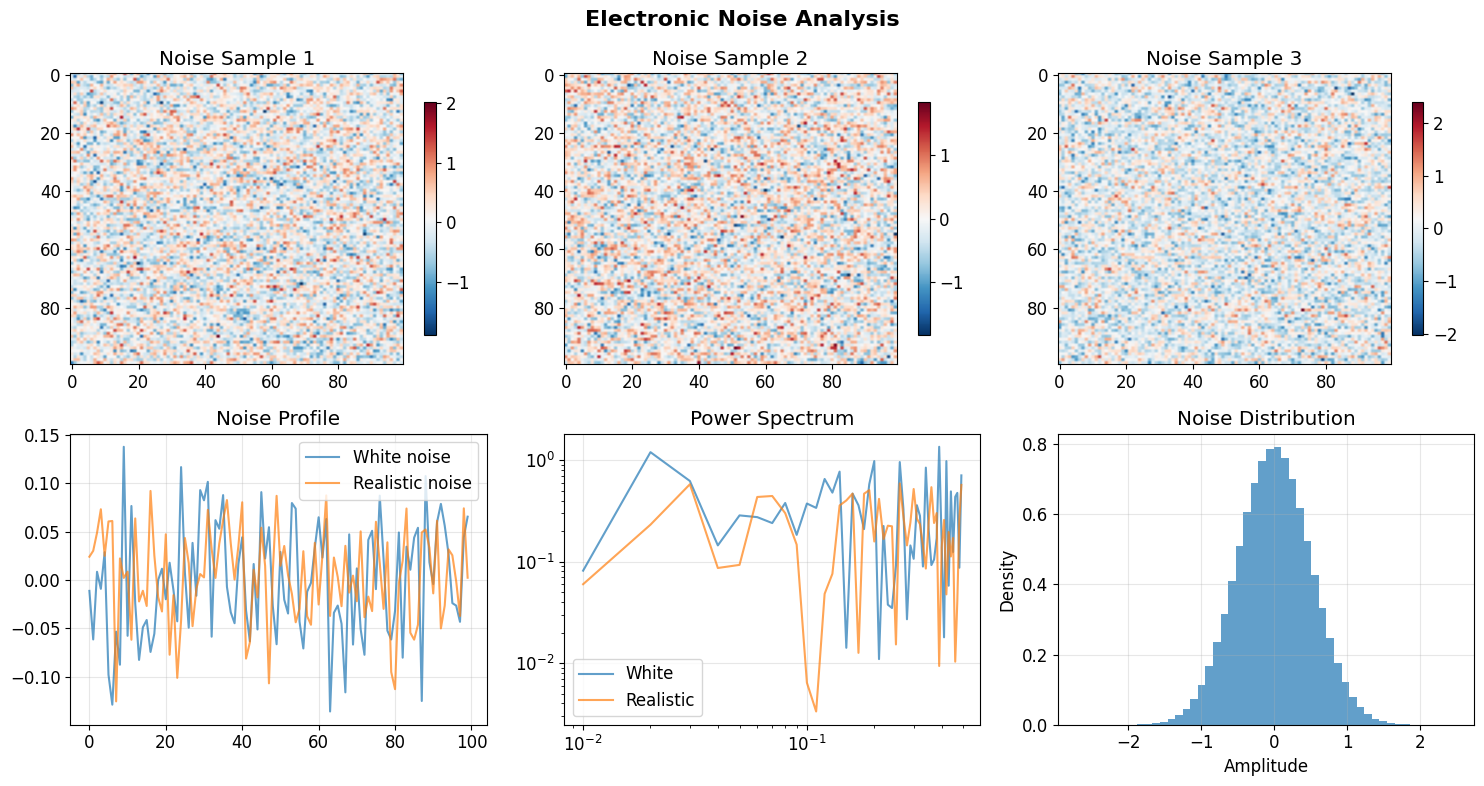

In [12]:
# Visualize noise characteristics
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
fig.suptitle('Electronic Noise Analysis', fontsize=16, fontweight='bold')

# Sample noise images
for i in range(3):
    im = axes[0, i].imshow(noise_images[i, :, :, 0], cmap='RdBu_r', aspect='auto')
    axes[0, i].set_title(f'Noise Sample {i+1}')
    plt.colorbar(im, ax=axes[0, i], shrink=0.8)

# Noise analysis
white_only = np.random.normal(0, noise_multiplier * 0.7, (100, 100))
realistic_noise = generate_electronic_noise((100, 100), 1, noise_multiplier, seed=123)[0,:,:,0]

# Noise Profile Visualisation
axes[1, 0].plot(np.mean(white_only, axis=0), label='White noise', alpha=0.7)
axes[1, 0].plot(np.mean(realistic_noise, axis=0), label='Realistic noise', alpha=0.7)
axes[1, 0].set_title('Noise Profile')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Power spectrum
white_fft = np.abs(np.fft.fft(np.mean(white_only, axis=0)))**2
realistic_fft = np.abs(np.fft.fft(np.mean(realistic_noise, axis=0)))**2
freqs = np.fft.fftfreq(100)

axes[1, 1].loglog(freqs[1:50], white_fft[1:50], label='White', alpha=0.7)
axes[1, 1].loglog(freqs[1:50], realistic_fft[1:50], label='Realistic', alpha=0.7)
axes[1, 1].set_title('Power Spectrum')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Noise statistics
noise_values = noise_images[:1000, :, :, 0].flatten()
axes[1, 2].hist(noise_values, bins=50, alpha=0.7, density=True)
axes[1, 2].set_title('Noise Distribution')
axes[1, 2].set_xlabel('Amplitude')
axes[1, 2].set_ylabel('Density')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

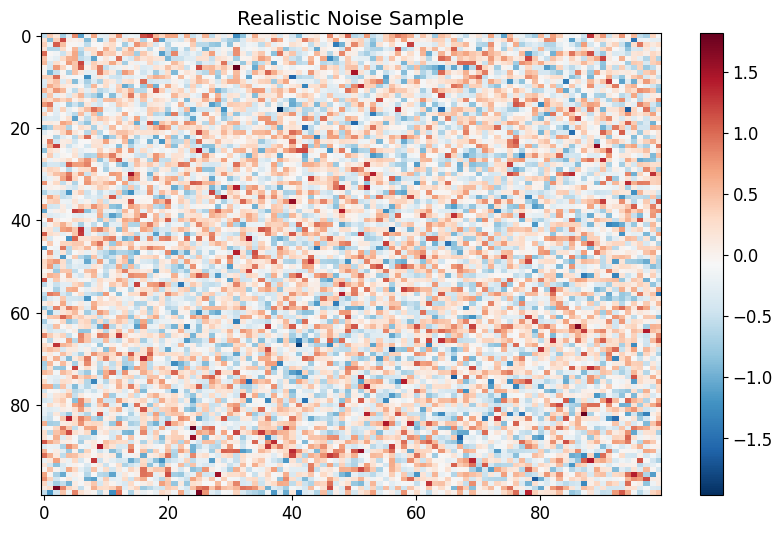

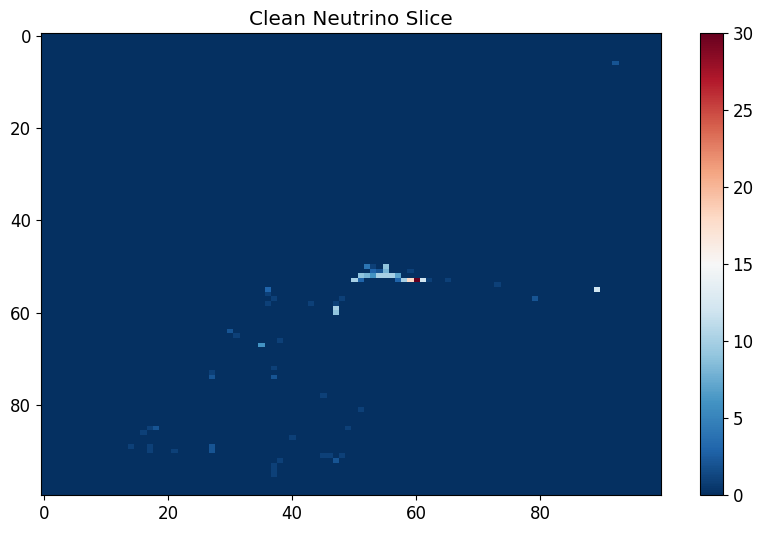

In [13]:
# Plot a singular noise sample from realistic_noise
plt.figure()
plt.imshow(realistic_noise, cmap='RdBu_r', aspect='auto')
plt.title('Realistic Noise Sample')
plt.colorbar()
plt.show()

# Plot a clean neutrino slice
plt.figure()
plt.imshow(images[0], cmap='RdBu_r', aspect='auto')
plt.title('Clean Neutrino Slice')
plt.colorbar()
plt.show()

# Task 2: Simple CNN Classifier - Clean Slices vs. Pure Noise
We now build a simple CNN classifier to identify clean neutrino slices from pure noise.

In [14]:
def build_simple_cnn(input_shape):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(2, activation='sigmoid') # sigmoid for binary classification (softmax for multi-class)
    ])

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [15]:
def generate_dataset(noise_multiplier, overlaid_noise=False,seed=None, radioactive_noise=False):
    """
    Generate a dataset of neutrino and noise images.

    Args:
        noise_multiplier: Array - the amplitude of the noise to add to the images.
        overlaid: Whether to overlay the noise on the neutrino slices.
        seed: The seed for the random number generator.
        radioactive_noise: Whether to add radioactive noise to the images.
    """
    clean_slices = images.copy()

    if overlaid_noise:
        # Calculate exact number of noise samples needed per level
        base_per_level = len(images) // len(noise_multiplier)
        remainder = len(images) % len(noise_multiplier)
        
        # Generate noise - slightly fewer samples that we'll then replicate to exact size
        pure_noise_temp = generate_electronic_noise((100, 100), base_per_level, noise_multiplier, seed=seed)
        overlaid_noise_temp = generate_electronic_noise((100, 100), base_per_level, noise_multiplier, seed=seed)
        
        # Handle remainder by replicating samples to get exact count
        if remainder > 0:
            pure_noise_slices = np.concatenate([pure_noise_temp, pure_noise_temp[:remainder]], axis=0)
            overlaid_noise_addition = np.concatenate([overlaid_noise_temp, overlaid_noise_temp[:remainder]], axis=0)
        else:
            pure_noise_slices = pure_noise_temp
            overlaid_noise_addition = overlaid_noise_temp
            
        overlaid_noise_slices = clean_slices + overlaid_noise_addition
        # Combine clean slices and pure noise slices; X = images, Y = labels
        X_combined = np.concatenate((overlaid_noise_slices, pure_noise_slices), axis=0)
        y_combined = np.concatenate((np.ones(len(overlaid_noise_slices)), np.zeros(len(pure_noise_slices))), axis=0)

    else:
        # Calculate exact number of noise samples needed per level
        base_per_level = len(images) // len(noise_multiplier)
        remainder = len(images) % len(noise_multiplier)
        
        # Generate noise - slightly fewer samples that we'll then replicate to exact size
        pure_noise_temp = generate_electronic_noise((100, 100), base_per_level, noise_multiplier, seed=seed)
        
        # Handle remainder by replicating samples to get exact count
        if remainder > 0:
            pure_noise_slices = np.concatenate([pure_noise_temp, pure_noise_temp[:remainder]], axis=0)
        else:
            pure_noise_slices = pure_noise_temp
        
        # Combine clean slices and pure noise slices; X = images, Y = labels
        X_combined = np.concatenate((clean_slices, pure_noise_slices), axis=0)
        y_combined = np.concatenate((np.ones(len(clean_slices)), np.zeros(len(pure_noise_slices))), axis=0)

    if radioactive_noise:
        X_combined += generate_radioactive_noise((100,100),len(X_combined),1.5,seed=None)
        # Plot a clean neutrino slice
        plt.figure()
        plt.imshow(X_combined[0], cmap='RdBu_r', aspect='auto')
        plt.title('Neutrino Slice with Electronic and Radioactive Noise')
        plt.colorbar()
        plt.show()

    # Split into training and `temporary` data splits
    X_train, X_temp, y_train, y_temp = train_test_split(
        X_combined, y_combined, test_size=0.3, random_state=42, stratify=y_combined
    )
    # Split temporary data into validation and test sets
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
    )

    # Convert labels to one-hot encoding
    y_train = to_categorical(y_train, num_classes=2)
    y_val = to_categorical(y_val, num_classes=2)
    y_test = to_categorical(y_test, num_classes=2)

    return X_train, X_val, X_test, y_train, y_val, y_test

In [16]:
def plot_model_performance(history, y_pred_proba, y_test):
    """
    Plot the performance of the model.
    """
    y_pred = np.argmax(y_pred_proba, axis=1)
    y_test = np.argmax(y_test, axis=1) 

    # Visualize results
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Enhanced CNN Training Results', fontsize=16, fontweight='bold')

    # Training curves
    axes[0, 0].plot(history.history['loss'], label='Training', linewidth=2)
    axes[0, 0].plot(history.history['val_loss'], label='Validation', linewidth=2)
    axes[0, 0].set_title('Model Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    axes[0, 1].plot(history.history['accuracy'], label='Training', linewidth=2)
    axes[0, 1].plot(history.history['val_accuracy'], label='Validation', linewidth=2)
    axes[0, 1].set_title('Model Accuracy')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 0],
                xticklabels=['Noise', 'Signal'], yticklabels=['Noise', 'Signal'])
    axes[1, 0].set_title('Confusion Matrix')
    axes[1, 0].set_xlabel('Predicted')
    axes[1, 0].set_ylabel('True')

    # ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba.argmax(axis=1))
    roc_auc = auc(fpr, tpr)
    axes[1, 1].plot(fpr, tpr, linewidth=2, label=f'ROC (AUC = {roc_auc:.3f})')
    axes[1, 1].plot([0, 1], [0, 1], 'k--', linewidth=1)
    axes[1, 1].set_xlabel('False Positive Rate')
    axes[1, 1].set_ylabel('True Positive Rate')
    axes[1, 1].set_title('ROC Curve')
    axes[1, 1].legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

Now let's train our simple model and test it on clean neutrino slices vs. pure electronic noise.

Model architecture:


/Users/alexpugeat/Documents/Github/SNEWS Project 2/snews/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 98, 98, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 47, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 33856)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     2,166,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,185,794 (8.34 MB)

 Trainable params: 2,185,794 (8.34 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - accuracy: 0.9829 - loss: 0.0661 - val_accuracy: 1.0000 - val_loss: 3.3908e-06
Epoch 2/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - accuracy: 0.9989 - loss: 0.0060 - val_accuracy: 1.0000 - val_loss: 7.6938e-07
Epoch 3/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - accuracy: 0.9998 - loss: 0.0012 - val_accuracy: 1.0000 - val_loss: 2.8344e-07
Epoch 4/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - accuracy: 0.9991 - loss: 0.0049 - val_accuracy: 1.0000 - val_loss: 4.4541e-07
Epoch 5/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - accuracy: 0.9990 - loss: 9.1170e-04 - val_accuracy: 1.0000 - val_loss: 8.0983e-08
Epoch 6/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - accuracy: 0.9994 - loss: 2.4790e-05 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 7/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - accuracy: 0.9994 - loss: 1.7261e-05 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 8/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/s

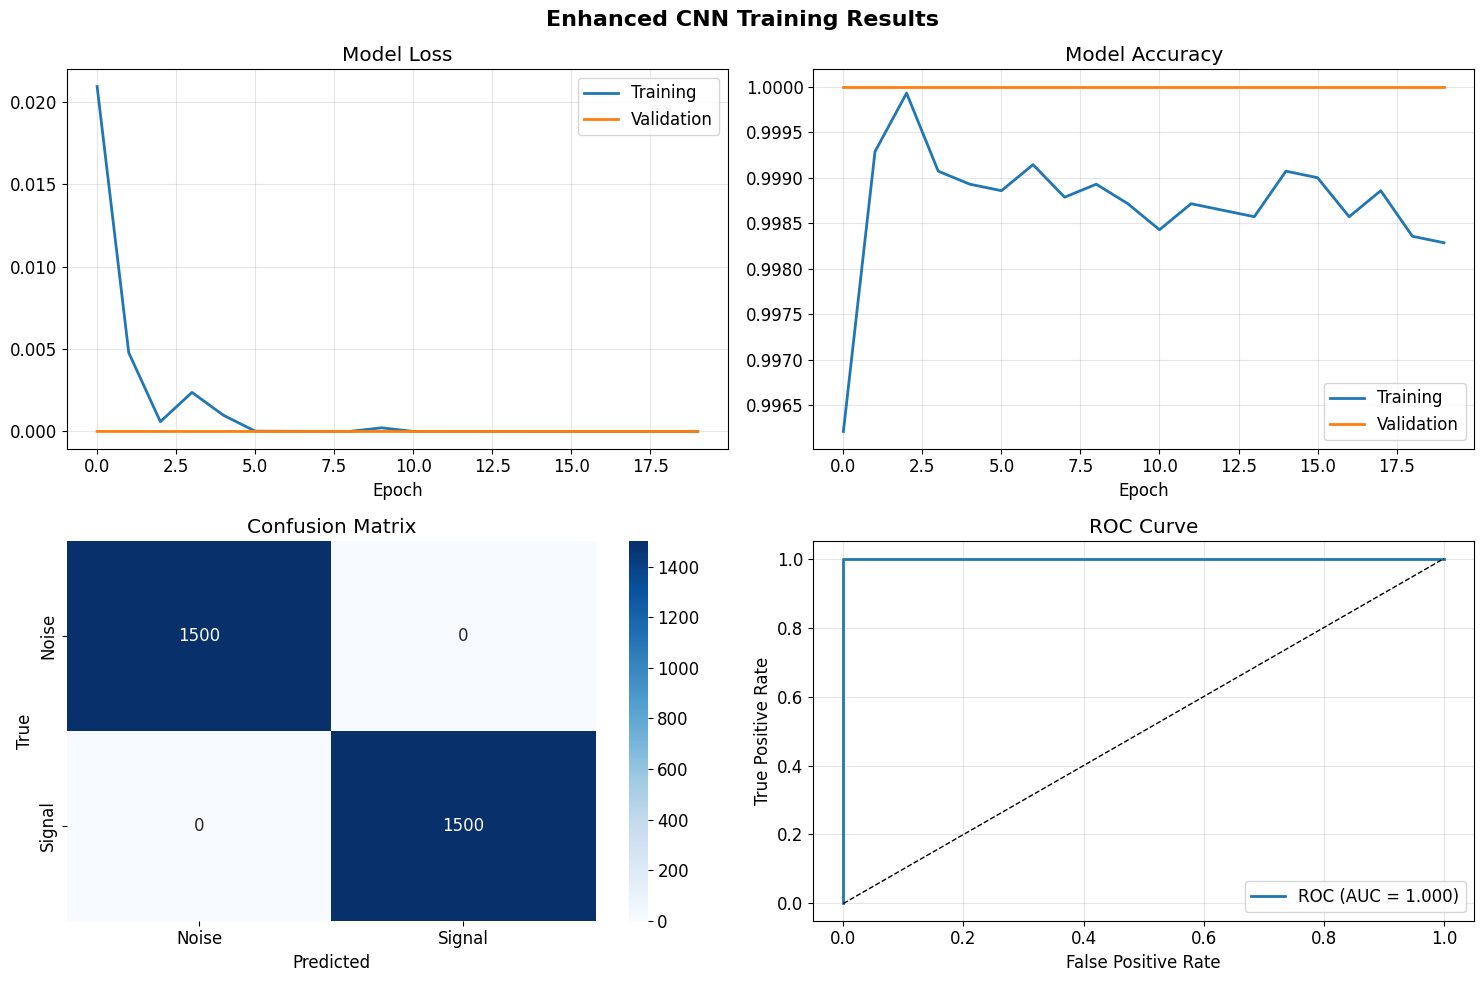

In [17]:
# Generate dataset
noise_amplitude = np.array([1,2,3])
X_train, X_val, X_test, y_train, y_val, y_test = generate_dataset(noise_amplitude, overlaid_noise=False, seed=123)

# Build model
model = build_simple_cnn((100, 100, 1))

print("Model architecture:")
model.summary()

# Train model
history = model.fit(
    X_train, y_train, 
    epochs=20, 
    batch_size=32, 
    validation_data=(X_val, y_val),
    verbose=1)

# Evaluate model
test_loss, test_accuracy = model.evaluate(X_test, y_test,verbose=1)
print(f"Test accuracy: {test_accuracy:.4f}")
y_pred_proba = model.predict(X_test)

plot_model_performance(history, y_pred_proba, y_test)

# Task 3: Classification Robustness Analysis
We now we train the same model on neutrino images superimposed with noise, and test the CNN's robustness by evaluating its performance on varying noise levels. This reveals how classifier performance degrades as noise increases.

In [18]:
noise_multiplier = np.array([0.5,1,2,4,8])

# New datasets with different levels of noise overlaid onto images
X_train, X_val, X_test, y_train, y_val, y_test = generate_dataset(noise_multiplier, overlaid_noise=True,seed=None, radioactive_noise=False)

Epoch 1/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - accuracy: 0.9526 - loss: 8.4204 - val_accuracy: 0.9817 - val_loss: 0.0460
Epoch 2/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - accuracy: 0.9868 - loss: 0.0360 - val_accuracy: 0.9843 - val_loss: 0.0427
Epoch 3/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - accuracy: 0.9921 - loss: 0.0210 - val_accuracy: 0.9857 - val_loss: 0.0492
Epoch 4/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - accuracy: 0.9969 - loss: 0.0091 - val_accuracy: 0.9873 - val_loss: 0.0476
Epoch 5/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - accuracy: 0.9981 - loss: 0.0060 - val_accuracy: 0.9833 - val_loss: 0.0611
Epoch 6/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - accuracy: 0.9983 - loss: 0.0045 - val_accuracy: 0.9870 - val_loss: 0.0534
Epoch 7/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - accuracy: 0.9974 - loss: 0.0076 - val_accuracy: 0.9847 - val_loss: 0.0637
Epoch 8/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - accuracy: 0.9988 - loss: 0.0053 - 

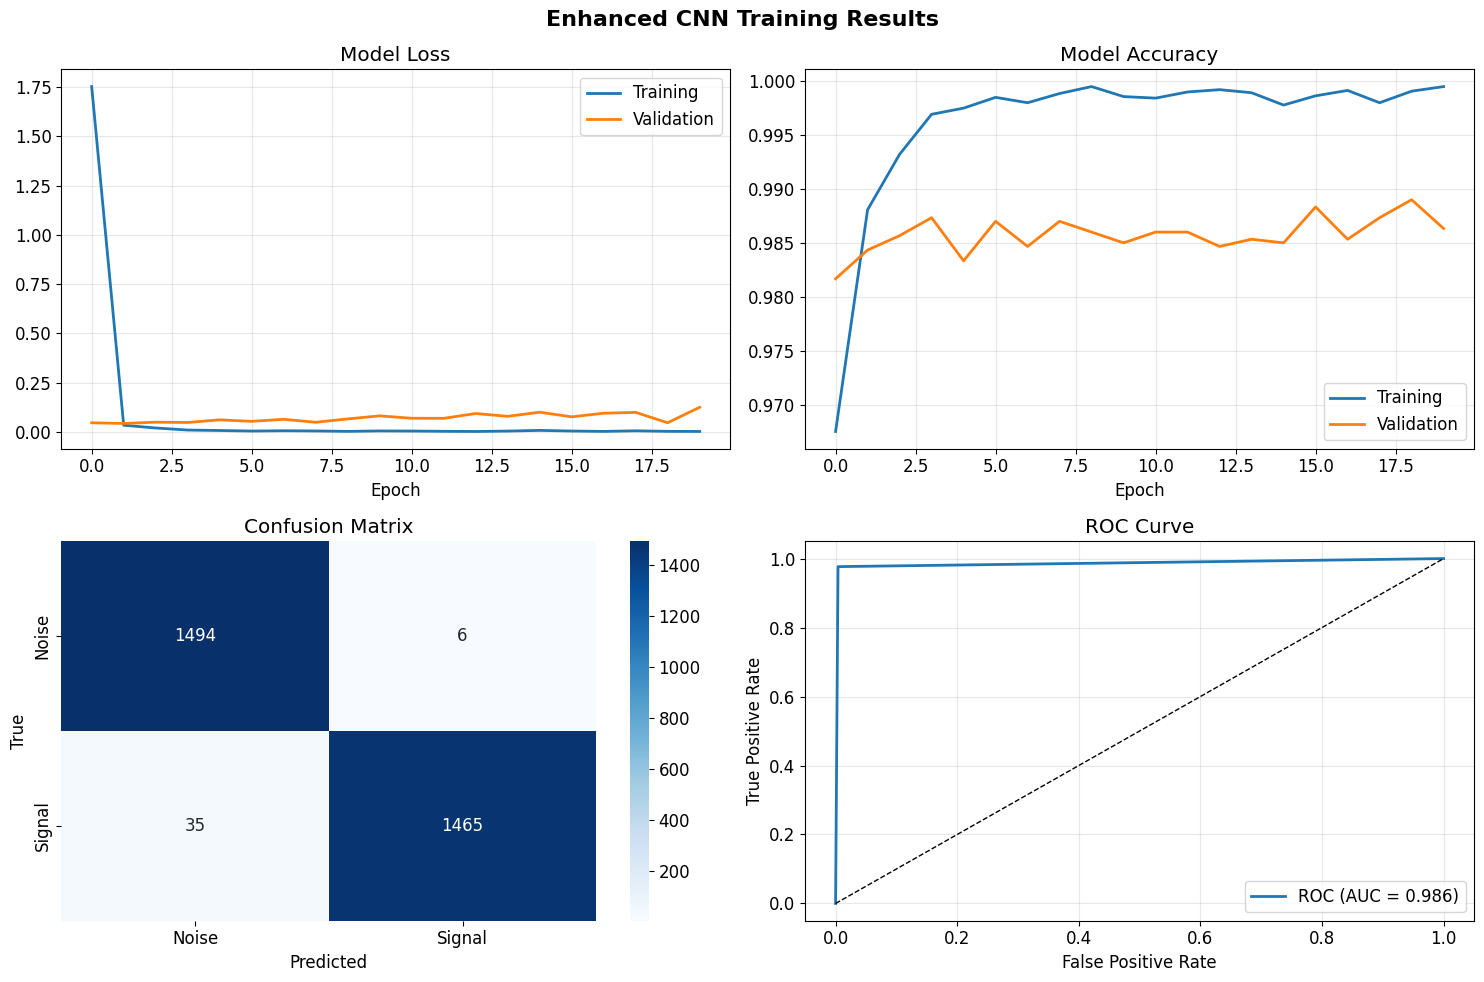

In [19]:
# Train same model on new dataset
history = model.fit(
    X_train, y_train, 
    epochs=20, 
    batch_size=32, 
    validation_data=(X_val, y_val),
    verbose=1)

# Evaluate model
test_loss, test_accuracy = model.evaluate(X_test, y_test,verbose=1)
print(f"Test accuracy: {test_accuracy:.4f}")
y_pred_proba = model.predict(X_test)

plot_model_performance(history, y_pred_proba, y_test)

(0.0, 1.05)

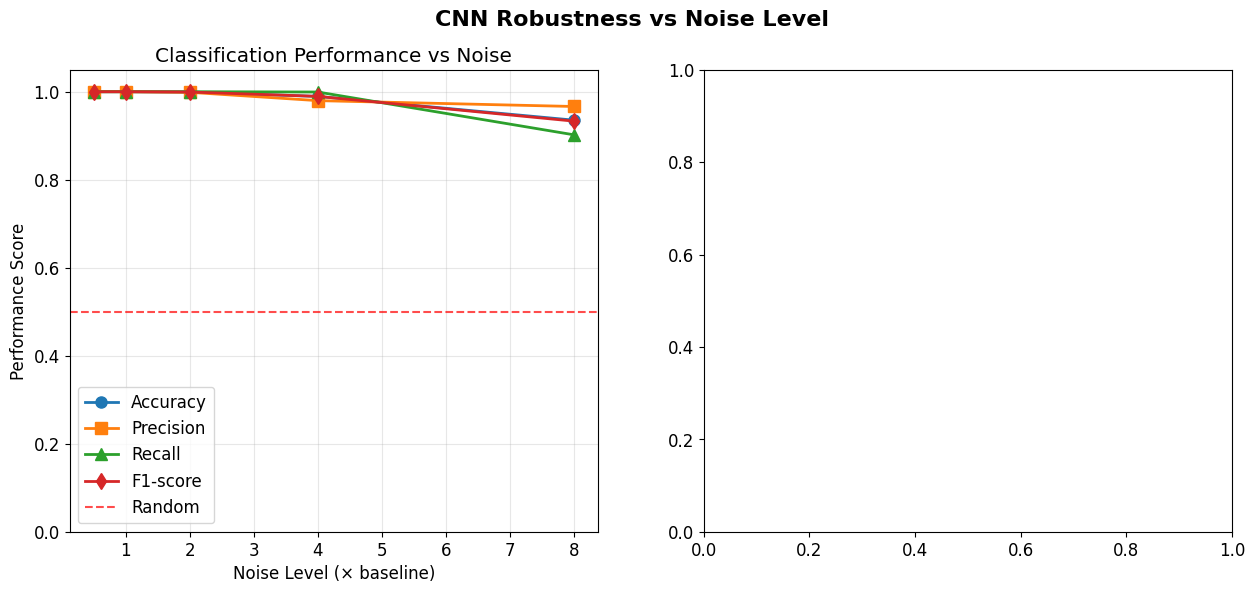

In [20]:
# Store robustness results
robustness_results = {
    'noise_levels': noise_multiplier,
    'accuracies': [],
    'precisions': [],
    'recalls': [],
    'f1_scores': []
}

# Test Robustness of Model with varying noise levels
for noise_level in noise_multiplier:
    # Geenrate dataset for this iteration of noise
    X_train, X_val, X_test, y_train, y_val, y_test = generate_dataset(np.array([noise_level]), overlaid_noise=True,seed=None, radioactive_noise=False)

    # Have model generate probability prediction for 1 (positive neutrino) 0 (no neutrino)
    y_pred_proba = model.predict(X_test,verbose=0)
    y_pred_binary = y_pred_proba.argmax(axis=1)
    y_test_binary = y_test.argmax(axis=1)

    # Calculate Robustness Metrics
    accuracy = accuracy_score(y_test_binary, y_pred_binary)
    precision = precision_score(y_test_binary, y_pred_binary)
    recall = recall_score(y_test_binary, y_pred_binary)
    f1 = f1_score(y_test_binary, y_pred_binary)

    # Update robustness results
    robustness_results['accuracies'].append(accuracy)
    robustness_results['precisions'].append(precision)
    robustness_results['recalls'].append(recall)
    robustness_results['f1_scores'].append(f1)

# Visualise Robustness of Model
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('CNN Robustness vs Noise Level', fontsize=16, fontweight='bold')

# Performance vs noise level
axes[0].plot(noise_multiplier, robustness_results['accuracies'], 'o-', linewidth=2, markersize=8, label='Accuracy')
axes[0].plot(noise_multiplier, robustness_results['precisions'], 's-', linewidth=2, markersize=8, label='Precision')
axes[0].plot(noise_multiplier, robustness_results['recalls'], '^-', linewidth=2, markersize=8, label='Recall')
axes[0].plot(noise_multiplier, robustness_results['f1_scores'], 'd-', linewidth=2, markersize=8, label='F1-score')

axes[0].axhline(y=0.5, color='red', linestyle='--', alpha=0.7, label='Random')
axes[0].set_xlabel('Noise Level (× baseline)')
axes[0].set_ylabel('Performance Score')
axes[0].set_title('Classification Performance vs Noise')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim(0, 1.05)

In [21]:
# Visualise sample images with different noise levels
noise_levels_for_visualisation = [1,4,8]
noise_samples = []
for current_noise_level in noise_levels_for_visualisation:
    image_sample = images[0].copy()
    noise = generate_electronic_noise((100, 100), 1, np.array([current_noise_level]), seed=0)[0,:,:,0]

    image_sample[:, :, 0] += noise
    noise_samples.append(image_sample)

comparison = np.concatenate([
    images[0, :, :, 0],
    noise_samples[0][:, :, 0],
    noise_samples[1][:, :, 0],
    noise_samples[2][:, :, 0]
], axis=1)

im = axes[1].imshow(comparison, cmap='viridis', aspect='auto')
axes[1].set_title('Neutrino Event with Increasing Noise')
axes[1].set_xticks([50, 150, 250, 350])
axes[1].set_xticklabels(['Clean', '1x noise', '4.0× noise', '8.0× noise'])
axes[1].set_ylabel('Y Position (pixels)')
plt.colorbar(im, ax=axes[1], shrink=0.8)

plt.tight_layout()
plt.show()

/var/folders/p2/k51tfdfd4k1dsdfzbs653xkh0000gn/T/ipykernel_10966/2861824626.py:23: UserWarning: Adding colorbar to a different Figure <Figure size 1500x600 with 3 Axes> than <Figure size 1000x600 with 0 Axes> which fig.colorbar is called on.
  plt.colorbar(im, ax=axes[1], shrink=0.8)


<Figure size 1000x600 with 0 Axes>

In [22]:
# Summary
baseline_acc = robustness_results['accuracies'][1]  # 1.0x noise
final_acc = robustness_results['accuracies'][-1]    # 5.0x noise
relative_drop = (baseline_acc - final_acc) / baseline_acc * 100

print(f"\nRobustness Analysis Summary:")
print(f"  Baseline accuracy (1.0x): {baseline_acc:.1%}")
print(f"  High noise accuracy (5.0x): {final_acc:.1%}")
print(f"  Performance drop: {relative_drop:.1f}%")


Robustness Analysis Summary:
  Baseline accuracy (1.0x): 100.0%
  High noise accuracy (5.0x): 93.5%
  Performance drop: 6.5%


# Task 4: Generating Radioactive Noise
We implement a physics-based radioactive noise simulation that models ³⁹Ar β⁻ decay with realistic parameters including Poisson-distributed decay counts, energy-dependent track lengths, and proper intensity scaling.

The modeling considers the following:

1. Poisson-Distributed Event Count
    - Radioactive decay follows Poisson statistics, thus a Poisson distirbution is used to model the number of decay events per image

2. 39Ar Beta Decay Spectrum
    - Argon-39 contamination is the primary source of radioactive noise in liquid argon detectors. 
    - Thus, the following features can be determined:<br>
            a. Q-value: 565 keV (maximum energy)<br>
            b. Decay energy spectrum formula: $N(E) \propto E \times (E_max - E)^2$

3. Electron Range Calculation
    - Electron range in liquid argon is given by $R(cm) \approx 0.31 * E^1.8$
    - We can convert this range to pixels within the image via an assumption of 1mm per pixel detector resolution.

4. Anisotropic Track Creation
    - Considers that electron tracks will have random orientations

5. Bragg Curve Implementation
    - Particles deposit more energy towards the end of their path, known as the Bragg Curve.

6. Energy Deposition
    - The blob size depends on energy deposited. 
    - The event's amplitude accounts for its energy and Bragg curve.



In [23]:
def generate_radioactive_noise(image_shape, image_count, contamination_rate, seed=None):
    """Generate radioactive noise for LArTPC detectors.
    
    Args:
        image_shape: Tuple of individual image dimensions (height, width)
        image_count: Number of images to generate for each noise leve
        contamination_rate: The rate of contamination for each image
        seed: Seed for random number generator
    """
    # Input validation
    if not isinstance(image_shape, (tuple, list)) or len(image_shape) != 2:
        raise ValueError("image_shape must be a tuple/list of (height, width)")
    if not isinstance(image_count, int) or image_count <= 0:
        raise ValueError("image_count must be a positive integer")
    if not isinstance(contamination_rate, (int, float)) or contamination_rate < 0:
        raise ValueError("contamination_rate must be a non-negative number")
    
    if seed is not None:
        np.random.seed(seed)
    
    height,width = image_shape
    noise_images = np.zeros((image_count, height, width, 1))

    for current_image in range(image_count):
        # Number of decays for this current image
        n_decays = np.random.poisson(contamination_rate)

        for _ in range(n_decays):
            # Randomise decay position, avoiding edges
            center_x = np.random.uniform(10, width - 10)
            center_y = np.random.uniform(10, height - 10)

            # Sample decay energy from 39Ar spectrum (Q = 565 keV)
            q_value = 0.565  # q-value (maximum energy possible)

            # Keep iterating until a valid energy is produced
            while True:
                E = np.random.uniform(0, q_value)
                prob = E * (q_value - E)**2

                # Normalise the probability to the q-value
                if np.random.random() < prob / (q_value**3 / 27):
                    decay_energy = E
                    break

            # Calculate how far electron travels in image
            range_cm = 0.31 * decay_energy**1.8
            range_pixels = range_cm * 10  # approximation: 1mm = 1 pixel

            # Calculate track direction and convert to pixels
            track_angle = np.random.uniform(0, 2*np.pi)
            track_length = range_pixels * np.random.uniform(0.7, 1.3)

            # Track endpoints with trig
            end_x = center_x + track_length * np.cos(track_angle)
            end_y = center_y + track_length * np.sin(track_angle)

            # Create track-like signature
            n_points = max(3, int(track_length / 2))
            for i in range(n_points):
                t = i / (n_points - 1)
                x = int(center_x + t * (end_x - center_x))
                y = int(center_y + t * (end_y - center_y))

                if 0 <= x < width and 0 <= y < height:
                    # Bragg curve: more energy at end
                    bragg_factor = 1.0 + 2.0 * t

                    # Energy-dependent blob size
                    sigma = 1.0 + 0.5 * np.sqrt(decay_energy)
                    amplitude = decay_energy * bragg_factor * typical_signal_strength
                    
                    # Add Gaussian blob
                    for dy in range(-3, 4):
                        for dx in range(-3, 4):
                            px, py = x + dx, y + dy
                            if 0 <= px < width and 0 <= py < height:
                                dist_sq = dx**2 + dy**2
                                intensity = amplitude * np.exp(-dist_sq / (2 * sigma**2))
                                noise_images[current_image, py, px] += intensity
    
    return noise_images.astype(np.float32)

In [24]:
# Generate radioactive noise dataset
radioactive_noise_images = generate_radioactive_noise((100, 100), 1000, 1.5, seed=43)

# Data properties
print(f"\nRadioactive noise dataset: {radioactive_noise_images.shape}")
print(f"Mean energy per image: {np.mean(np.sum(radioactive_noise_images, axis=(1,2,3))):.3f}")
print(f"Average blobs per image: ~{1.5:.1f} (Poisson λ)")


Radioactive noise dataset: (1000, 100, 100, 1)
Mean energy per image: 106.634
Average blobs per image: ~1.5 (Poisson λ)


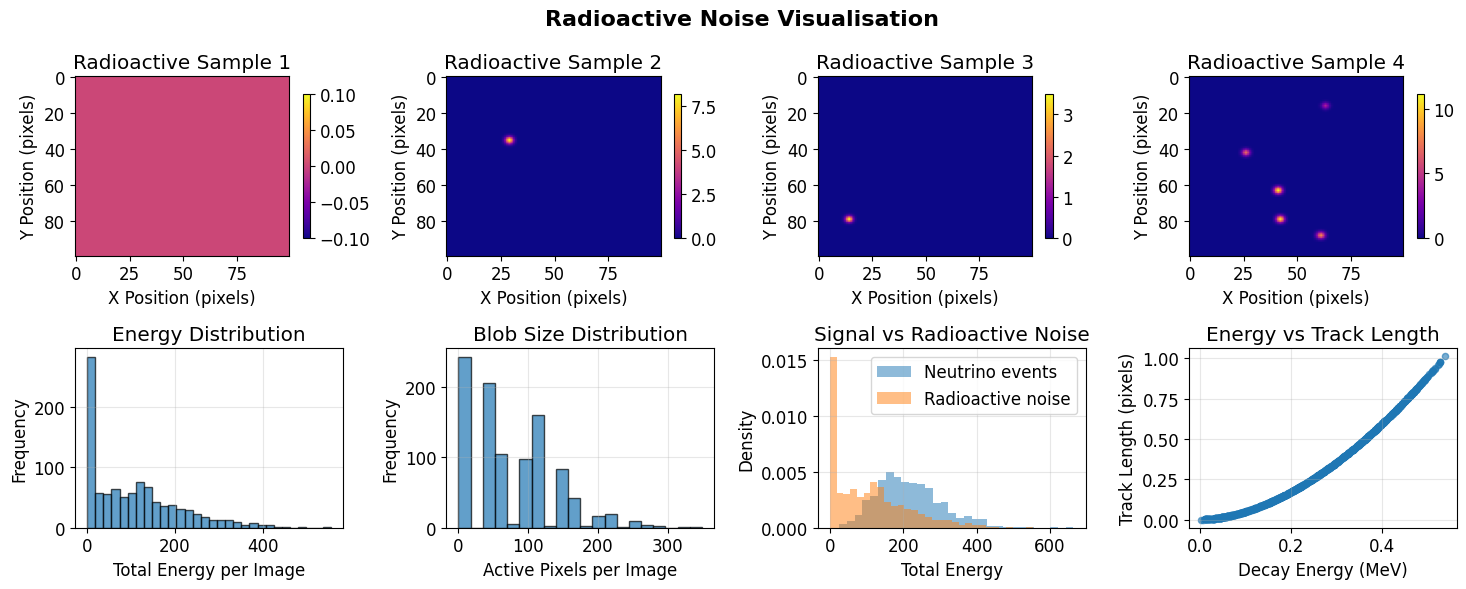

In [25]:
# Visualise radioactive noise
fig,axes = plt.subplots(2,4,figsize=(15,6))
fig.suptitle('Radioactive Noise Visualisation', fontsize=16, fontweight='bold')

# Sample radioactive noise images
for i in range(4):
    im = axes[0, i].imshow(radioactive_noise_images[i, :, :, 0], cmap='plasma', aspect='auto')
    axes[0, i].set_title(f'Radioactive Sample {i+1}')
    axes[0, i].set_xlabel('X Position (pixels)')
    axes[0, i].set_ylabel('Y Position (pixels)')
    plt.colorbar(im, ax=axes[0, i], shrink=0.8)

# Analysis plots
total_energies = [np.sum(radioactive_noise_images[i, :, :, 0]) for i in range(1000)]
axes[1, 0].hist(total_energies, bins=30, alpha=0.7, edgecolor='black')
axes[1, 0].set_xlabel('Total Energy per Image')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Energy Distribution')
axes[1, 0].grid(True, alpha=0.3)

# Count active pixels (approximate blob count)
active_pixels = [np.count_nonzero(radioactive_noise_images[i, :, :, 0]) for i in range(1000)]
axes[1, 1].hist(active_pixels, bins=20, alpha=0.7, edgecolor='black')
axes[1, 1].set_xlabel('Active Pixels per Image')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Blob Size Distribution')
axes[1, 1].grid(True, alpha=0.3)

# Compare with neutrino signals
neutrino_energies_sample = [np.sum(images[i, :, :, 0]) for i in range(1000)]
axes[1, 2].hist(neutrino_energies_sample, bins=30, alpha=0.5, label='Neutrino events', density=True)
axes[1, 2].hist(total_energies, bins=30, alpha=0.5, label='Radioactive noise', density=True)
axes[1, 2].set_xlabel('Total Energy')
axes[1, 2].set_ylabel('Density')
axes[1, 2].set_title('Signal vs Radioactive Noise')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

# Track length analysis
# Generate sample tracks for analysis
track_lengths = []
energies = []
for _ in range(1000):
    max_energy = 0.565
    while True:
        E = np.random.uniform(0, max_energy)
        prob = E * (max_energy - E)**2
        if np.random.random() < prob / (max_energy**3 / 27):
            energy = E
            break
    range_cm = 0.31 * energy**1.8
    track_lengths.append(range_cm * 10)  # Convert to pixels
    energies.append(energy)

axes[1, 3].scatter(energies, track_lengths, alpha=0.6, s=20)
axes[1, 3].set_xlabel('Decay Energy (MeV)')
axes[1, 3].set_ylabel('Track Length (pixels)')
axes[1, 3].set_title('Energy vs Track Length')
axes[1, 3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Task 5: Energy Prediction CNN
We now build a CNN that determines the neutrino energy from a clean slice.

In [26]:
def build_energy_prediction_cnn(input_shape=(100, 100, 1)):
    """Build an improved CNN for neutrino energy regression."""
    model = Sequential([
        # Enhanced first block
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, padding='same'),
        BatchNormalization(),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.2),
        
        # Enhanced second block  
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.3),
        
        # Enhanced third block
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        GlobalAveragePooling2D(),  # Reduces parameters compared to Flatten
        
        # Enhanced dense layers
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='linear')  # Single output for energy regression
    ])
    
    # Better optimizer configuration
    model.compile(
        optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999),
        loss='mse',
        metrics=['mae']
    )
    
    return model

In [27]:
# Prepare data for energy prediction
print("Preparing data for neutrino energy prediction...")
X_energy = images.copy()  # Clean neutrino images
y_energy = neutrino_energies.copy()  # Energy targets

print(f"Energy prediction dataset:")
print(f"  Input shape: {X_energy.shape}")
print(f"  Energy range: {np.min(y_energy):.2f} - {np.max(y_energy):.2f} MeV")
print(f"  Mean energy: {np.mean(y_energy):.2f} MeV")

# Split data into train/validation/test sets
# Create energy bins for stratified splitting
energy_bins = np.digitize(y_energy, bins=np.percentile(y_energy, [25, 50, 75]))

X_train_energy, X_temp_energy, y_train_energy, y_temp_energy = train_test_split(
    X_energy, y_energy, test_size=0.3, random_state=42, stratify=energy_bins
)
X_val_energy, X_test_energy, y_val_energy, y_test_energy = train_test_split(
    X_temp_energy, y_temp_energy, test_size=0.5, random_state=42
)

print(f"\nData splits for energy prediction:")
print(f"  Training: {len(X_train_energy)} samples")
print(f"  Validation: {len(X_val_energy)} samples")
print(f"  Test: {len(X_test_energy)} samples")


Preparing data for neutrino energy prediction...
Energy prediction dataset:
  Input shape: (10000, 100, 100, 1)
  Energy range: 4.49 - 59.93 MeV
  Mean energy: 21.65 MeV

Data splits for energy prediction:
  Training: 7000 samples
  Validation: 1500 samples
  Test: 1500 samples


In [28]:
# Build and train energy prediction model
print("Building energy prediction CNN...")
energy_model = build_energy_prediction_cnn()

print("Model architecture:")
energy_model.summary()

# Enhanced training callbacks
energy_callbacks = [
    EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=8, min_lr=1e-6),
    ModelCheckpoint('artifacts/best_energy_model.keras', save_best_only=True, monitor='val_loss')
]

# Train the model
print("Training energy prediction model...")
energy_history = energy_model.fit(
    X_train_energy, y_train_energy,
    epochs=50,
    batch_size=32,
    validation_data=(X_val_energy, y_val_energy),
    callbacks=energy_callbacks,
    verbose=1
)

Building energy prediction CNN...
Model architecture:


/Users/alexpugeat/Documents/Github/SNEWS Project 2/snews/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 100, 100, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 100, 100, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 100, 100, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 50, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 50, 50, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 50, 50, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 25, 25, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 25, 25, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 25, 25, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 312,673 (1.19 MB)

 Trainable params: 311,969 (1.19 MB)

 Non-trainable params: 704 (2.75 KB)

Training energy prediction model...
Epoch 1/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 41s 183ms/step - loss: 302.7467 - mae: 14.6960 - val_loss: 38.5079 - val_mae: 4.3985 - learning_rate: 0.0010
Epoch 2/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 40s 184ms/step - loss: 48.0937 - mae: 5.2226 - val_loss: 944.0488 - val_mae: 30.2197 - learning_rate: 0.0010
Epoch 3/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 41s 189ms/step - loss: 44.7420 - mae: 5.0231 - val_loss: 55.1790 - val_mae: 6.8571 - learning_rate: 0.0010
Epoch 4/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 41s 186ms/step - loss: 40.4738 - mae: 4.7721 - val_loss: 22.0217 - val_mae: 3.5899 - learning_rate: 0.0010
Epoch 5/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 41s 186ms/step - loss: 36.6645 - mae: 4.5895 - val_loss: 35.7793 - val_mae: 5.1515 - learning_rate: 0.0010
Epoch 6/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 41s 186ms/step - loss: 34.2003 - mae: 4.4256 - val_loss: 22.8720 - val_mae: 3.7979 - learning_rate: 0.0010
Epoch 7/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 41s 188ms/step - loss: 35.7696 - mae: 

In [29]:
# Evaluate energy prediction model
print("Evaluating Energy Prediction CNN...")

# Make predictions
y_pred_energy = energy_model.predict(X_test_energy, verbose=0).flatten()

# Calculate regression metrics
test_mse = mean_absolute_error(y_test_energy, y_pred_energy)**2
test_mae = mean_absolute_error(y_test_energy, y_pred_energy)
test_r2 = r2_score(y_test_energy, y_pred_energy)
test_mape = np.mean(np.abs((y_test_energy - y_pred_energy) / y_test_energy)) * 100

print(f"\nEnergy Prediction Results:")
print(f"  Test MSE: {test_mse:.4f}")
print(f"  Test MAE: {test_mae:.4f} MeV")
print(f"  Test MAPE: {test_mape:.2f}%")
print(f"  R² Score: {test_r2:.4f}")

Evaluating Energy Prediction CNN...

Energy Prediction Results:
  Test MSE: 12.9541
  Test MAE: 3.5992 MeV
  Test MAPE: 17.69%
  R² Score: 0.6259


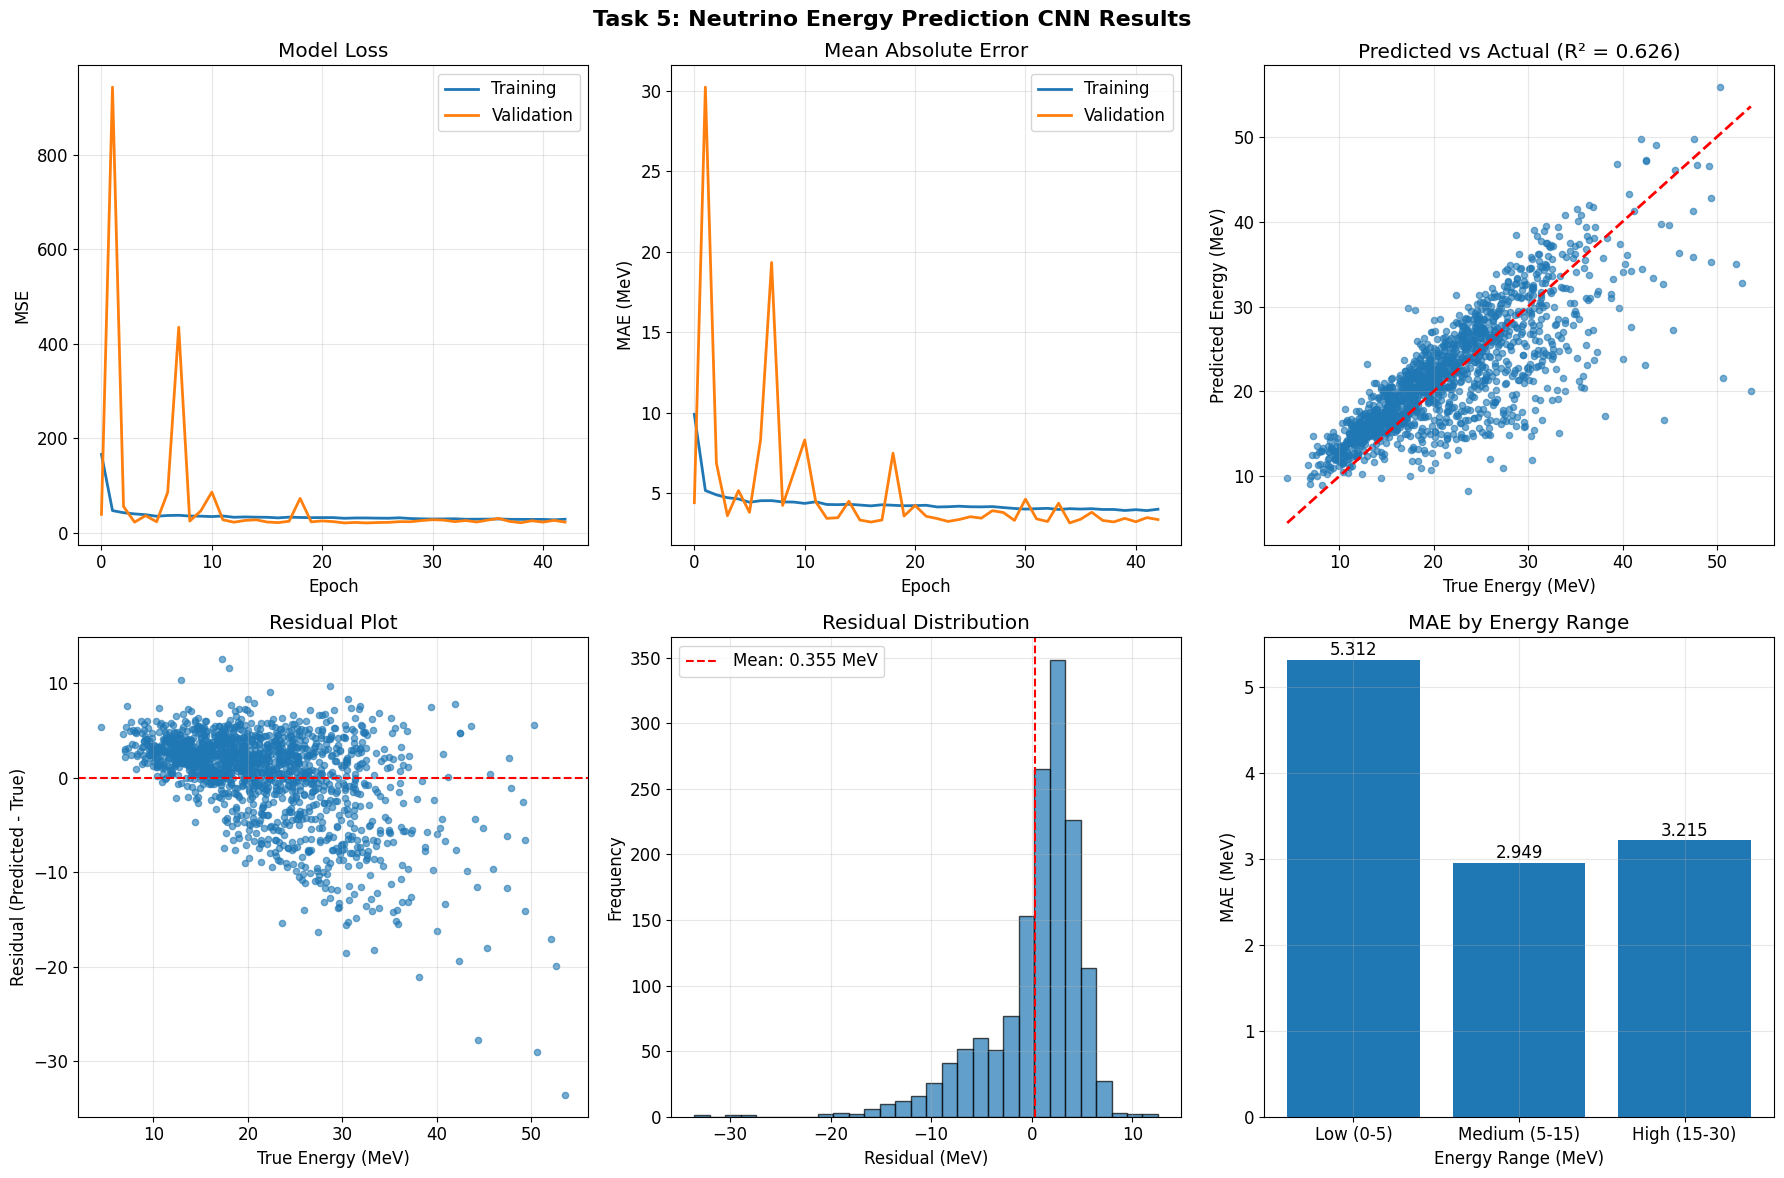

In [30]:
# Create comprehensive evaluation plots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Task 5: Neutrino Energy Prediction CNN Results', fontsize=16, fontweight='bold')

# Training curves
axes[0, 0].plot(energy_history.history['loss'], label='Training', linewidth=2)
axes[0, 0].plot(energy_history.history['val_loss'], label='Validation', linewidth=2)
axes[0, 0].set_title('Model Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('MSE')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(energy_history.history['mae'], label='Training', linewidth=2)
axes[0, 1].plot(energy_history.history['val_mae'], label='Validation', linewidth=2)
axes[0, 1].set_title('Mean Absolute Error')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('MAE (MeV)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Predicted vs Actual scatter plot
axes[0, 2].scatter(y_test_energy, y_pred_energy, alpha=0.6, s=20)
axes[0, 2].plot([y_test_energy.min(), y_test_energy.max()], 
               [y_test_energy.min(), y_test_energy.max()], 'r--', linewidth=2)
axes[0, 2].set_xlabel('True Energy (MeV)')
axes[0, 2].set_ylabel('Predicted Energy (MeV)')
axes[0, 2].set_title(f'Predicted vs Actual (R² = {test_r2:.3f})')
axes[0, 2].grid(True, alpha=0.3)

# Residual plot
residuals = y_pred_energy - y_test_energy
axes[1, 0].scatter(y_test_energy, residuals, alpha=0.6, s=20)
axes[1, 0].axhline(y=0, color='r', linestyle='--')
axes[1, 0].set_xlabel('True Energy (MeV)')
axes[1, 0].set_ylabel('Residual (Predicted - True)')
axes[1, 0].set_title('Residual Plot')
axes[1, 0].grid(True, alpha=0.3)

# Residual distribution
axes[1, 1].hist(residuals, bins=30, alpha=0.7, edgecolor='black')
axes[1, 1].axvline(np.mean(residuals), color='red', linestyle='--', 
                   label=f'Mean: {np.mean(residuals):.3f} MeV')
axes[1, 1].set_xlabel('Residual (MeV)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Residual Distribution')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Energy range performance
energy_ranges = [(0, 5), (5, 15), (15, 30)]
range_names = ['Low (0-5)', 'Medium (5-15)', 'High (15-30)']
range_maes = []

for (low, high), name in zip(energy_ranges, range_names):
    mask = (y_test_energy >= low) & (y_test_energy < high)
    if np.sum(mask) > 0:
        range_mae = mean_absolute_error(y_test_energy[mask], y_pred_energy[mask])
        range_maes.append(range_mae)
    else:
        range_maes.append(0)

axes[1, 2].bar(range_names, range_maes)
axes[1, 2].set_title('MAE by Energy Range')
axes[1, 2].set_xlabel('Energy Range (MeV)')
axes[1, 2].set_ylabel('MAE (MeV)')
axes[1, 2].grid(True, alpha=0.3)
for i, v in enumerate(range_maes):
    axes[1, 2].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

Sample Energy Predictions:


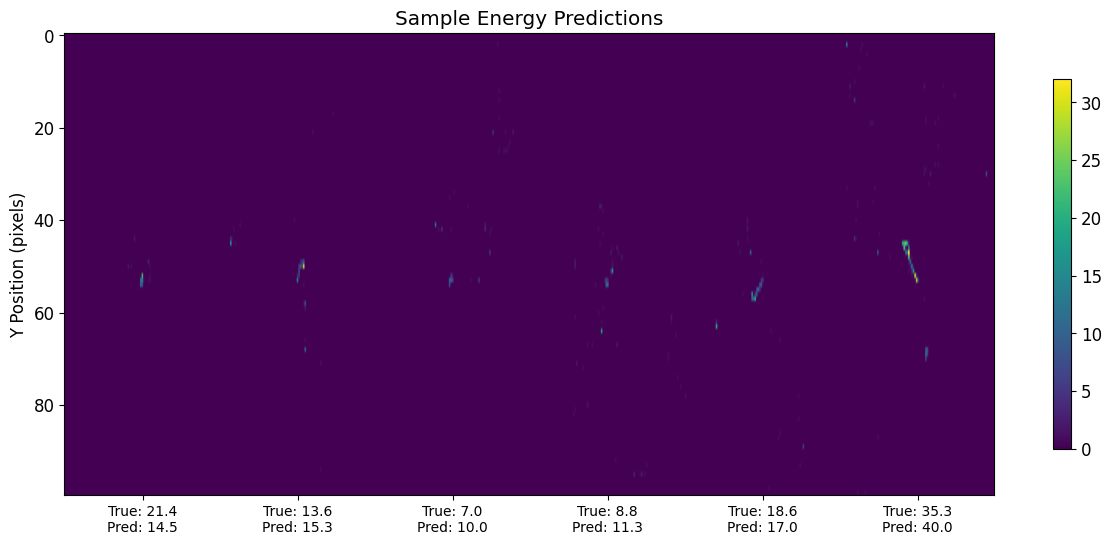

Task 5 Summary:
  Model parameters: 312,673
  Test MAE: 3.599 MeV
  Test R² Score: 0.626
  Training converged in 43 epochs
  Low (0-5) MeV range: 5.312 MAE (1 samples)
  Medium (5-15) MeV range: 2.949 MAE (333 samples)
  High (15-30) MeV range: 3.215 MAE (946 samples)

Task 5: Energy Prediction CNN completed successfully!


In [31]:
# Sample predictions visualization
print("Sample Energy Predictions:")
sample_indices = np.random.choice(len(X_test_energy), 6, replace=False)
sample_images = np.concatenate([X_test_energy[i, :, :, 0] for i in sample_indices], axis=1)
sample_true = [y_test_energy[i] for i in sample_indices]
sample_pred = [y_pred_energy[i] for i in sample_indices]

fig, ax = plt.subplots(1, 1, figsize=(15, 6))
im = ax.imshow(sample_images, cmap='viridis', aspect='auto')
ax.set_title('Sample Energy Predictions')
ax.set_xticks([50 + i*100 for i in range(6)])
ax.set_xticklabels([f'True: {t:.1f}\nPred: {p:.1f}' for t, p in zip(sample_true, sample_pred)], fontsize=10)
ax.set_ylabel('Y Position (pixels)')
plt.colorbar(im, ax=ax, shrink=0.8)
plt.show()

# Print detailed results
print(f"Task 5 Summary:")
print(f"  Model parameters: {energy_model.count_params():,}")
print(f"  Test MAE: {test_mae:.3f} MeV")
print(f"  Test R² Score: {test_r2:.3f}")
print(f"  Training converged in {len(energy_history.history['loss'])} epochs")

# Energy range analysis
for (low, high), name, mae in zip(energy_ranges, range_names, range_maes):
    mask = (y_test_energy >= low) & (y_test_energy < high)
    count = np.sum(mask)
    if count > 0:
        print(f"  {name} MeV range: {mae:.3f} MAE ({count} samples)")

print("\nTask 5: Energy Prediction CNN completed successfully!")

# Task 6: Simple Denoising Autoencoder

We implement a lightweight but effective autoencoder to remove electronic noise from neutrino images. The goal is to take noisy neutrino images as input and reconstruct clean neutrino images as output.

**Architecture Design:**
- **Encoder**: Progressively downsamples the input through convolutional layers
- **Bottleneck**: Compressed representation in the middle
- **Decoder**: Reconstructs the clean image using transposed convolutions and skip connections
- **Skip Connections**: Preserve fine details by connecting encoder and decoder layers

**Training Strategy:**
- Input: Noisy images (clean + electronic noise)
- Target: Original clean neutrino slices
- Loss: Mean Squared Error for pixel-wise reconstruction
- Regularization: Dropout and batch normalization for stability

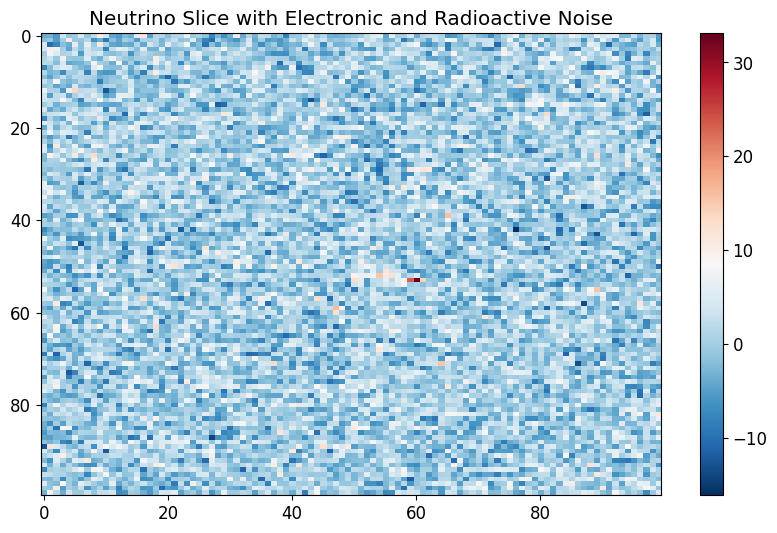

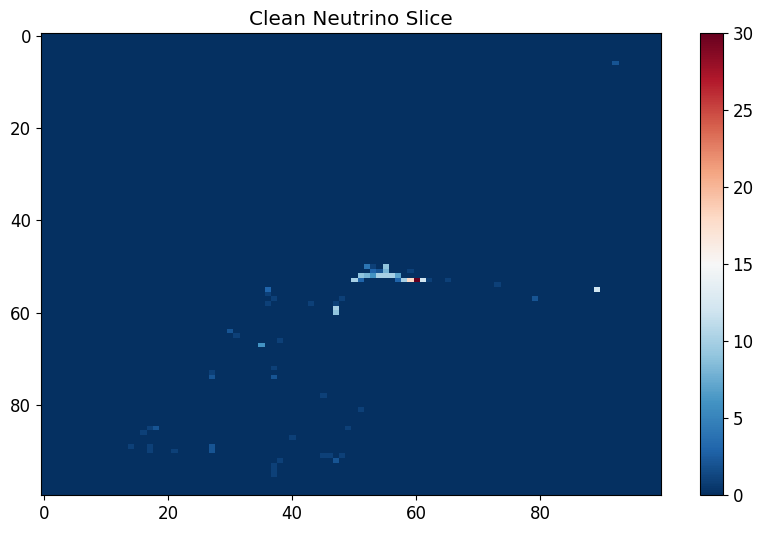

Preparing denoising training data...
Training samples: 7000
Validation samples: 1500


In [32]:
# Generate noisy training data
noise_multiplier = np.array([0.5, 1, 2, 4, 8])
X_train, X_val, X_test, y_train, y_val, y_test = generate_dataset(noise_multiplier, overlaid_noise=True, seed=None, radioactive_noise=True)

# Plot a clean neutrino slice
plt.figure()
plt.imshow(images[0], cmap='RdBu_r', aspect='auto')
plt.title('Clean Neutrino Slice')
plt.colorbar()
plt.show()

# Prepare clean training data for denoising
print("Preparing denoising training data...")
X_train_clean = X_train[y_train[:, 1] == 1]  # Clean neutrino images only
X_val_clean = X_val[y_val[:, 1] == 1]

# Add controlled noise to create input-output pairs
noise_strength = 0.1
X_train_noisy = X_train_clean + np.random.normal(0, noise_strength, X_train_clean.shape)
X_val_noisy = X_val_clean + np.random.normal(0, noise_strength, X_val_clean.shape)

print(f"Training samples: {len(X_train_clean)}")
print(f"Validation samples: {len(X_val_clean)}")

In [33]:
def build_simple_unet(input_shape=(100, 100, 1)):
    """Build a simple, readable U-Net for denoising."""
    
    inputs = Input(shape=input_shape)
    
    # Encoder (downsampling path)
    # Level 1
    conv1 = Conv2D(32, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    # Level 2
    conv2 = Conv2D(64, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    # Level 3 (bottleneck)
    conv3 = Conv2D(128, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, 3, activation='relu', padding='same')(conv3)
    
    # Decoder (upsampling path)
    # Level 2 decode
    up2 = UpSampling2D(size=(2, 2))(conv3)
    merge2 = Concatenate()([conv2, up2])  # Skip connection
    conv4 = Conv2D(64, 3, activation='relu', padding='same')(merge2)
    conv4 = Conv2D(64, 3, activation='relu', padding='same')(conv4)
    
    # Level 1 decode
    up1 = UpSampling2D(size=(2, 2))(conv4)
    merge1 = Concatenate()([conv1, up1])  # Skip connection
    conv5 = Conv2D(32, 3, activation='relu', padding='same')(merge1)
    conv5 = Conv2D(32, 3, activation='relu', padding='same')(conv5)
    
    # Output layer
    outputs = Conv2D(1, 1, activation='linear')(conv5)
    
    model = Model(inputs, outputs)
    return model

In [34]:
# Build and compile the simple model
print("Building simple U-Net denoising model...")
denoising_model = build_simple_unet()

denoising_model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

print(f"Model has {denoising_model.count_params():,} parameters")

# Simple callbacks
callbacks_list = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7)
]

# Train the model
print("Training denoising model...")
history = denoising_model.fit(
    X_train_noisy, X_train_clean,
    batch_size=16,
    epochs=50,
    validation_data=(X_val_noisy, X_val_clean),
    callbacks=callbacks_list,
    verbose=1
)

Building simple U-Net denoising model...
Model has 470,977 parameters
Training denoising model...
Epoch 1/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 110s 249ms/step - loss: 0.4475 - mae: 0.2017 - val_loss: 0.0134 - val_mae: 0.0494 - learning_rate: 0.0010
Epoch 2/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 109s 249ms/step - loss: 0.0160 - mae: 0.0504 - val_loss: 0.0082 - val_mae: 0.0369 - learning_rate: 0.0010
Epoch 3/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 109s 249ms/step - loss: 0.0115 - mae: 0.0409 - val_loss: 0.0072 - val_mae: 0.0345 - learning_rate: 0.0010
Epoch 4/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 109s 249ms/step - loss: 0.0103 - mae: 0.0382 - val_loss: 0.0048 - val_mae: 0.0286 - learning_rate: 0.0010
Epoch 5/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 109s 249ms/step - loss: 0.0066 - mae: 0.0312 - val_loss: 0.0072 - val_mae: 0.0347 - learning_rate: 0.0010
Epoch 6/50
438/438 ━━━━━━━━━━━━━━━━━━━━ 109s 250ms/step - loss: 0.0261 - mae: 0.0529 - val_loss: 0.0038 - val_mae: 0.0252 - learning_rate: 0.0010
Epoch 7/50
438/438 ━━━━━━━


Evaluating denoising performance...
Test Loss (MSE): 0.002184
Test MAE: 0.018282
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


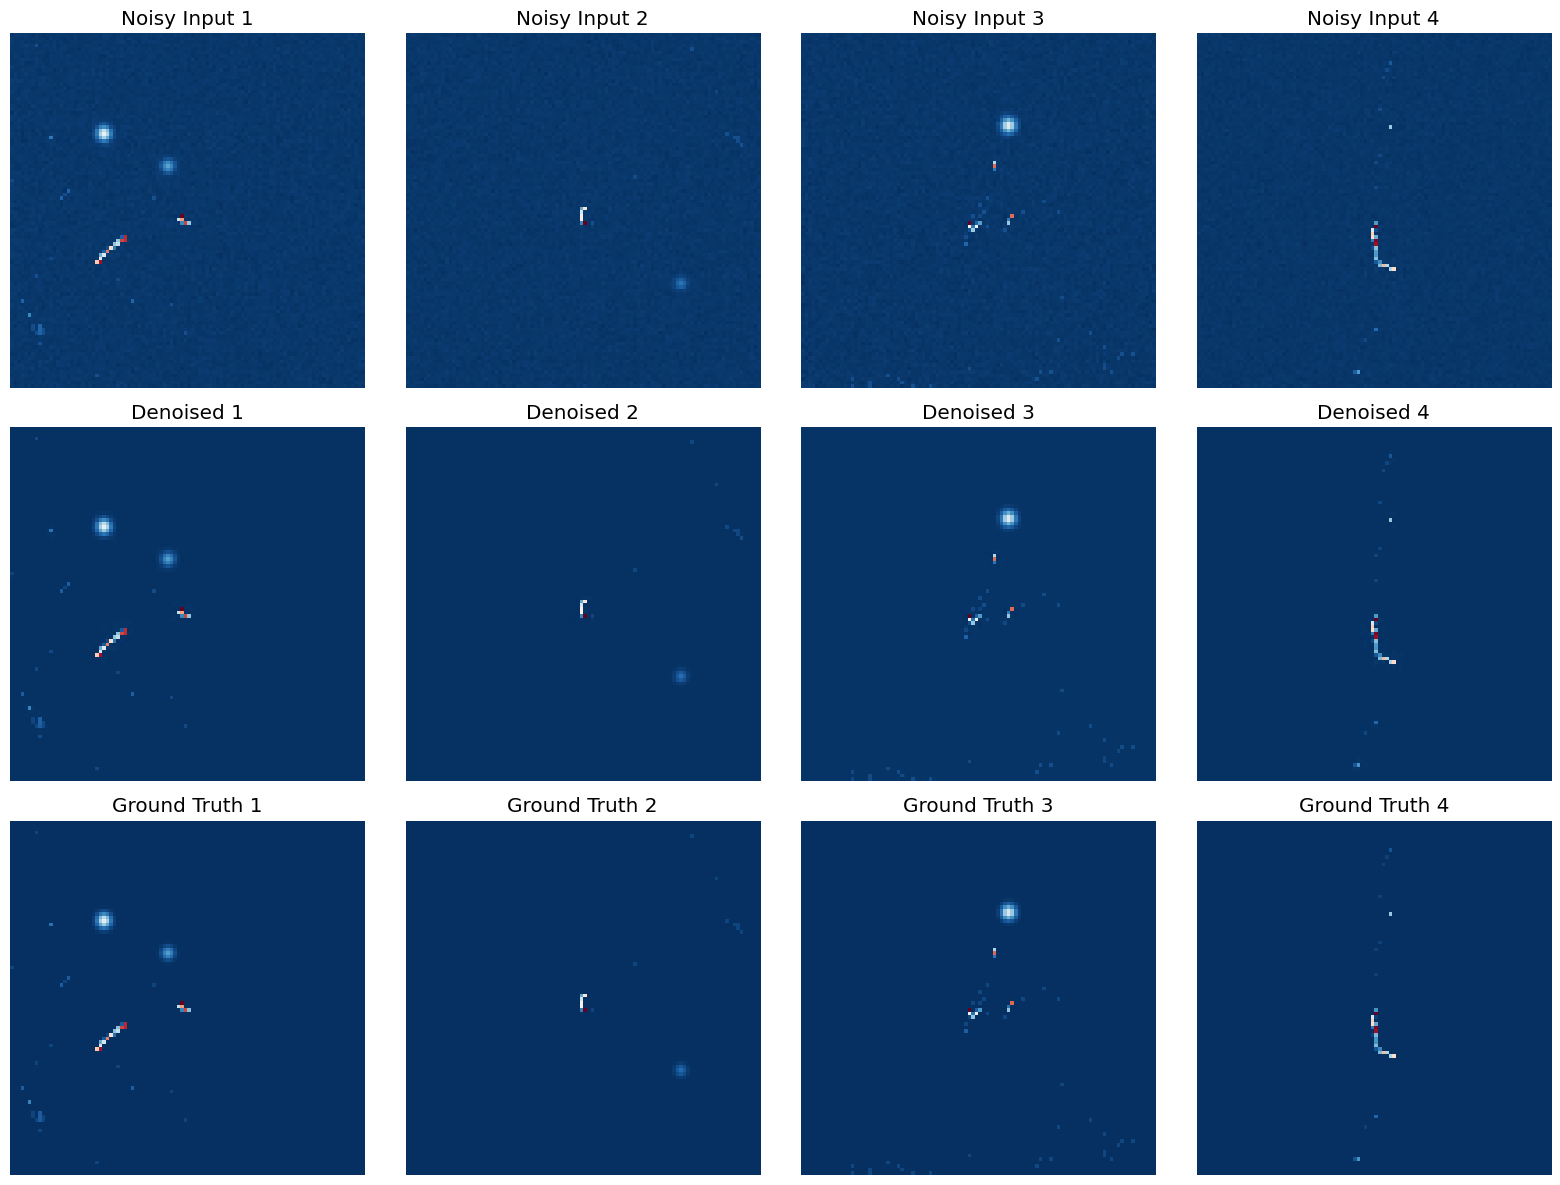

In [35]:
# Evaluate the model
print("\nEvaluating denoising performance...")
test_loss, test_mae = denoising_model.evaluate(X_val_noisy, X_val_clean, verbose=0)
print(f"Test Loss (MSE): {test_loss:.6f}")
print(f"Test MAE: {test_mae:.6f}")

# Generate some denoised examples
sample_predictions = denoising_model.predict(X_val_noisy[:4])

# Plot comparison
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
for i in range(4):
    # Original noisy
    axes[0, i].imshow(X_val_noisy[i, :, :, 0], cmap='RdBu_r')
    axes[0, i].set_title(f'Noisy Input {i+1}')
    axes[0, i].axis('off')
    
    # Denoised
    axes[1, i].imshow(sample_predictions[i, :, :, 0], cmap='RdBu_r')
    axes[1, i].set_title(f'Denoised {i+1}')
    axes[1, i].axis('off')
    
    # Original clean
    axes[2, i].imshow(X_val_clean[i, :, :, 0], cmap='RdBu_r')
    axes[2, i].set_title(f'Ground Truth {i+1}')
    axes[2, i].axis('off')

plt.tight_layout()
plt.show()

# Task 7: Determining the number of final particles in an image slice

Here, we build a multi-class CNN to 

In [37]:
# Load clean neutrino images and particle counts
images_clean = images.copy()  # Use clean images as specified
final_particle_count = metadata[:,3].astype(int)  # Extract final particle count

print(f"\nParticle Count Statistics:")
print(f"  Range: {np.min(final_particle_count)} - {np.max(final_particle_count)} particles")
print(f"  Mean: {np.mean(final_particle_count):.1f} particles")
print(f"  Unique counts: {np.unique(final_particle_count)}")

# Analyze class distribution and filter by minimum sample count
unique_counts, class_frequencies = np.unique(final_particle_count, return_counts=True)
print(f"\nFull Class Distribution:")
for count, freq in zip(unique_counts, class_frequencies):
    print(f"  {count} particles: {freq} samples ({freq/len(final_particle_count)*100:.1f}%)")


Particle Count Statistics:
  Range: 3 - 10 particles
  Mean: 5.2 particles
  Unique counts: [ 3  4  5  6  7  8  9 10]

Full Class Distribution:
  3 particles: 536 samples (5.4%)
  4 particles: 1002 samples (10.0%)
  5 particles: 5106 samples (51.1%)
  6 particles: 2833 samples (28.3%)
  7 particles: 500 samples (5.0%)
  8 particles: 20 samples (0.2%)
  9 particles: 2 samples (0.0%)
  10 particles: 1 samples (0.0%)


It is evident that the 8,9 and 10 particle classes have far too few samples. Ideally, we have at least 100 samples to sort into training, test and validation images. Thus, we can omit these classes. The alternative is to augment them using rotation, zoom, horizontal/vertical flipping, but this does not create robust models capable of prediction.

We then stratify the remaining data to ensure that in the training, test and validation datasets, each dataset has a sufficient number of each class.

In [38]:
# Filter classes with minimum 100 samples for robust stratified splitting
min_samples_per_class = 100
valid_classes = []
valid_class_counts = []

for count, freq in zip(unique_counts, class_frequencies):
    if freq >= min_samples_per_class:
        valid_classes.append(count)
        valid_class_counts.append(freq)

print(f"\nClasses with >= {min_samples_per_class} samples:")
for count, freq in zip(valid_classes, valid_class_counts):
    print(f"  {count} particles: {freq} samples ({freq/sum(valid_class_counts)*100:.1f}% of filtered)")

# Filter dataset to only include classes with sufficient samples
valid_mask = np.isin(final_particle_count, valid_classes)
images_filtered = images_clean[valid_mask]
particle_counts_filtered = final_particle_count[valid_mask]

print(f"\nFiltered dataset: {len(images_filtered)} samples ({len(images_filtered)/len(images_clean)*100:.1f}% of original)")

# Prepare data for classification using filtered classes
num_classes = len(valid_classes)
print(f"\nPreparing {num_classes}-class dataset for Bayesian optimization...")

# Create class mapping for filtered classes (map particle counts to sequential class indices)
class_mapping_filtered = {count: idx for idx, count in enumerate(valid_classes)}
y_classes_filtered = np.array([class_mapping_filtered[count] for count in particle_counts_filtered])

# Convert to one-hot encoding
y_categorical_filtered = to_categorical(y_classes_filtered, num_classes=num_classes)

# Stratified split ensuring all classes appear in each split (70/15/15 distribution)
X_train, X_temp, y_train, y_temp = train_test_split(
    images_filtered, y_categorical_filtered, 
    test_size=0.3, random_state=42, 
    stratify=y_categorical_filtered  # Stratified to ensure class balance
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, 
    test_size=0.5, random_state=42, 
    stratify=y_temp  # Maintain stratification in val/test split
)

print(f"Data splits:")
print(f"  Training: {len(X_train)} samples")
print(f"  Validation: {len(X_val)} samples") 
print(f"  Test: {len(X_test)} samples")


Classes with >= 100 samples:
  3 particles: 536 samples (5.4% of filtered)
  4 particles: 1002 samples (10.0% of filtered)
  5 particles: 5106 samples (51.2% of filtered)
  6 particles: 2833 samples (28.4% of filtered)
  7 particles: 500 samples (5.0% of filtered)

Filtered dataset: 9977 samples (99.8% of original)

Preparing 5-class dataset for Bayesian optimization...
Data splits:
  Training: 6983 samples
  Validation: 1497 samples
  Test: 1497 samples


Now we define the CNN architecture. It is a simple CNN setup using softmax for multi-class classification. However, upon trialing a number of architectures, validation accuracy peaked at only 50-60%. 

It was then decided to use Keras Tuner to trial a great number of architectures to identify the strongest classifier using this setup. Hyperparameters were set for the number of conv blocks, the filter sizing, kernel size, dropout, dense layers, and learning rate. These were optimised using Bayesian Optimisation. Hyperband optimisation was also considered due to speed, but Bayesian Optimisation, although being slower, is known to identify the strongest architecture in the long run. 

In [39]:
# Tunable CNN architecture function
def build_tunable_particle_cnn(hp):
    """Build a tunable CNN for multi-class particle count classification."""
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(100, 100, 1)))
    
    # Tunable number of convolutional blocks (2-4 to prevent overfit)
    num_blocks = hp.Int('num_conv_blocks', min_value=2, max_value=4)
    
    for i in range(num_blocks):
        # Progressive filter sizing with tunable options
        if i == 0:
            filters = hp.Choice(f'filters_block_{i}', [16, 32])
        elif i == 1:
            filters = hp.Choice(f'filters_block_{i}', [32, 64])
        else:
            filters = hp.Choice(f'filters_block_{i}', [64, 128])
        
        # Tunable kernel size
        kernel_size = hp.Choice(f'kernel_size_{i}', [3, 5])
        
        # L2 regularization
        l2_reg = hp.Float(f'l2_reg_{i}', 1e-5, 1e-3, sampling='log')
        
        model.add(tf.keras.layers.Conv2D(
            filters, kernel_size, activation='relu', padding='same',
            kernel_regularizer=tf.keras.regularizers.l2(l2_reg)
        ))
        
        # Optional batch normalization
        if hp.Boolean(f'batch_norm_{i}'):
            model.add(tf.keras.layers.BatchNormalization())
        
        model.add(tf.keras.layers.MaxPooling2D(2))
        
        # Tunable dropout after each block
        dropout_rate = hp.Float(f'dropout_conv_{i}', 0.1, 0.5)
        model.add(tf.keras.layers.Dropout(dropout_rate))
    
    # Global pooling (proven effective)
    model.add(tf.keras.layers.GlobalAveragePooling2D())
    
    # Tunable dense architecture
    num_dense = hp.Int('num_dense_layers', 1, 2)
    for i in range(num_dense):
        units = hp.Choice(f'dense_units_{i}', [32, 64, 128])
        model.add(tf.keras.layers.Dense(units, activation='relu'))
        dropout_rate = hp.Float(f'dropout_dense_{i}', 0.2, 0.7)
        model.add(tf.keras.layers.Dropout(dropout_rate))
    
    # Output layer
    model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))
    
    # Tunable optimizer settings
    learning_rate = hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [42]:
# Set up Bayesian Optimization
print("\nSetting up Bayesian Optimization tuner...")

tuner = kt.BayesianOptimization(
    build_tunable_particle_cnn,
    objective=kt.Objective('val_accuracy', direction='max'),
    max_trials=50,  # Reduced for reasonable runtime
    executions_per_trial=2,  # Multiple runs per config for reliability
    directory='particle_count_tuning',
    project_name='neutrino_particle_count',
    overwrite=True
)

print("Tuner search space summary:")
tuner.search_space_summary()


Setting up Bayesian Optimization tuner...
Tuner search space summary:
Search space summary
Default search space size: 15
num_conv_blocks (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 4, 'step': 1, 'sampling': 'linear'}
filters_block_0 (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32], 'ordered': True}
kernel_size_0 (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
l2_reg_0 (Float)
{'default': 1e-05, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.001, 'step': None, 'sampling': 'log'}
batch_norm_0 (Boolean)
{'default': False, 'conditions': []}
dropout_conv_0 (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': None, 'sampling': 'linear'}
filters_block_1 (Choice)
{'default': 32, 'conditions': [], 'values': [32, 64], 'ordered': True}
kernel_size_1 (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
l2_reg_1 (Float)
{'default': 1e-05, 'conditions': [], 'min_value

In [ ]:
# Search for best hyperparameters
print("\nStarting Bayesian optimization search...")
print("This will systematically search for optimal architecture to reduce overfitting...")

# Enhanced callbacks for hyperparameter search
search_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
]

# Perform hyperparameter search
tuner.search(
    X_train, y_train,
    epochs=30,  # Reasonable epoch limit per trial
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=search_callbacks,
    verbose=1
)

print("\nBayesian optimization completed!")

# Get best hyperparameters and model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("\nBest Hyperparameters:")
print(f"  Number of conv blocks: {best_hps.get('num_conv_blocks')}")
print(f"  Learning rate: {best_hps.get('learning_rate'):.2e}")
for i in range(best_hps.get('num_conv_blocks')):
    print(f"  Block {i}: {best_hps.get(f'filters_block_{i}')} filters, kernel {best_hps.get(f'kernel_size_{i}')}x{best_hps.get(f'kernel_size_{i}')}")
    print(f"    L2 reg: {best_hps.get(f'l2_reg_{i}'):.2e}, Dropout: {best_hps.get(f'dropout_conv_{i}'):.3f}")
    print(f"    Batch norm: {best_hps.get(f'batch_norm_{i}')}")

Trial 37 Complete [00h 08m 11s]
val_accuracy: 0.5497661828994751

Best val_accuracy So Far: 0.5748163163661957
Total elapsed time: 08h 14m 11s

Search: Running Trial #38

Value             |Best Value So Far |Hyperparameter
4                 |4                 |num_conv_blocks
32                |32                |filters_block_0
5                 |3                 |kernel_size_0
8.5411e-05        |2.5362e-05        |l2_reg_0
True              |True              |batch_norm_0
0.36372           |0.4303            |dropout_conv_0
64                |32                |filters_block_1
3                 |3                 |kernel_size_1
0.00013383        |2.2063e-05        |l2_reg_1
True              |False             |batch_norm_1
0.2513            |0.26676           |dropout_conv_1
1                 |1                 |num_dense_layers
64                |64                |dense_units_0
0.39377           |0.50982           |dropout_dense_0
0.0094805         |0.0015013         |learning_

In [ ]:
# Build and train best model with more epochs
print("\nBuilding and training the best model...")
best_model = tuner.hypermodel.build(best_hps)
print(f"\nOptimized Model Architecture (Parameters: {best_model.count_params():,}):")
best_model.summary()

# Train best model with enhanced callbacks
final_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=25, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=8, min_lr=1e-7),
    tf.keras.callbacks.ModelCheckpoint('artifacts/best_model.keras', save_best_only=True, monitor='val_accuracy')
]

# Final training
history = best_model.fit(
    X_train, y_train,
    epochs=100,  # More epochs for final model
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=final_callbacks,
    verbose=1
)

### Evaluation

In [ ]:
# Evaluate the model
print("Evaluating Task 7: Particle Count Classification")

# Make predictions with optimized model
y_pred_proba = best_model.predict(X_test, verbose=0)
y_pred_classes = np.argmax(y_pred_proba, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Calculate metrics
test_accuracy = accuracy_score(y_test_classes, y_pred_classes)
print(f"\nTest Accuracy: {test_accuracy:.4f}")

# Detailed classification report using filtered class names
class_names_filtered = [f"{count} particles" for count in valid_classes]
print("\nClassification Report:")
print(classification_report(y_test_classes, y_pred_classes, target_names=class_names_filtered))

# Create comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Task 7: Multi-class Particle Count CNN Results', fontsize=16, fontweight='bold')

# Training curves
axes[0, 0].plot(history.history['loss'], label='Training', linewidth=2)
axes[0, 0].plot(history.history['val_loss'], label='Validation', linewidth=2)
axes[0, 0].set_title('Model Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(history.history['accuracy'], label='Training', linewidth=2)
axes[0, 1].plot(history.history['val_accuracy'], label='Validation', linewidth=2)
axes[0, 1].set_title('Model Accuracy')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Conclusions



## Todos:

CODE & ANALYSES:

MARKDOWN & COMMENTS:<br>
[ ] Add in-text citations for references